In [1]:
'''
Date: 8/11/2021
Auther: Yike Xie
Content: cell-cell communication with Tregs
'''


'\nDate: 8/11/2021\nAuther: Yike Xie\nContent: cell-cell communication with Tregs\n'

In [2]:
import os

import numpy as np
import pandas as pd

import anndata
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

from collections import defaultdict
import random
import itertools
from numpy import *    

In [3]:
import sys
sys.path.append('/home/yike/phd/dengue/dengue_children') #enter the YK_util file directory
sys.path.append('/home/yike/phd/dengue/dengue_children/paper_figures') #enter the YK_util file directory
import YK_util, optimized_pair_comparison_new, functions_CCC_figure_fra_pair
from YK_util import *
from optimized_pair_comparison_new import *
from functions_CCC_figure_fra_pair import *

In [4]:
path = '/home/yike/phd/dengue/data/mergedata_20211001.h5ad'
adata = sc.read_h5ad(path)
adata_kid = subsetdata(adata)
adata_kid = normalizedata(adata_kid, log1p=True) # log1p = 2
adata_kid = removegenes(adata_kid)
# batch 1:
# patient 6_029_01: 
# only contains cells in ['Plasmablasts', 'doublets', 'B_cells', 'T_cells', 'NK_cells']

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [9]:
print('Load interaction') 

fn_int = '/home/yike/phd/dengue/data/interaction_source_file/omni_DB_inters.tsv'
interactions = pd.read_csv(fn_int, sep='\t')
inter_genes = np.unique(interactions[['genesymbol_intercell_source', 'genesymbol_intercell_target']])
inter_genes = [gene for gene in inter_genes if gene in adata_kid.var_names]

def check_inters(gene):
    inters = interactions[(interactions['genesymbol_intercell_source'] == gene) | 
             (interactions['genesymbol_intercell_target'] == gene)]
    return inters

save_tabels = '/home/yike/phd/dengue/data/tables/dataset_20211001/'
save_figures = '/home/yike/phd/dengue/figures/paper_figure/dataset_20211001/'

Load interaction


In [ ]:
ct_pair = pd.read_csv(save_tabels + 'ct_data_pair_gene_cut_0.tsv', sep='\t', index_col=['cell_subtype', 'gene'])
ct_log2FC = pd.read_csv(save_tabels + 'ct_log2FC_gene_cut_0.tsv', sep='\t', index_col=0)

cst_pair = pd.read_csv(save_tabels + 'cst_data_pair_gene_cut_0.tsv', sep='\t', index_col=['cell_subtype', 'gene'])
cst_log2FC = pd.read_csv(save_tabels + 'cst_log2FC_gene_cut_0.tsv', sep='\t', index_col=0)

# define T regs

In [94]:
'''
T cells expressing IL2RA or FOXP3
'''
kid_T = adata_kid[adata_kid.obs['cell_type_new'] == 'T_cells'] # 19603
cond = kid_T[(kid_T[:, 'IL2RA'].X.toarray() > 0) | (kid_T[:, 'FOXP3'].X.toarray() > 0)] # 420
uncond = adata_kid[~ ((adata_kid[:, 'IL2RA'].X.toarray() > 0) | (adata_kid[:, 'FOXP3'].X.toarray() > 0))] # 111517

adata_kid.obs.loc[cond.obs_names, 'Treg'] = 'yes'
adata_kid.obs.loc[uncond.obs_names, 'Treg'] = 'no'

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [57]:
adata_kid.obs['Treg'].value_counts()

no     111571
yes       420
Name: Treg, dtype: int64

In [59]:
adata_kid[adata_kid.obs['cell_type_new'] == 'T_cells'].obs[['Treg', 'cell_subtype_new', ]].value_counts()

Treg  cell_subtype_new         
no    CD4+ T cells                 11134
      CD8+ effector T cells         4890
      CD8+ naive/memory T cells     3159
yes   CD4+ T cells                   322
      CD8+ effector T cells           89
      CD8+ naive/memory T cells        9
dtype: int64

# fraction of Tregs

In [7]:
'''
fraction of Tregs at different conditions
'''

'\nfraction of Tregs at different conditions\n'

In [60]:
kid_T = adata_kid[adata_kid.obs['cell_type_new'] == 'T_cells']

In [67]:
df = kid_T.obs[['cell_subtype_new', 'Condition', 'Treg']].groupby(['Treg', 'cell_subtype_new', 'Condition']).size().unstack()
df_treg = df.loc['yes']

In [86]:
df

Condition                       DWS  Healthy  S_dengue  dengue
Treg cell_subtype_new                                         
no   CD4+ T cells               844     2231      5000    3059
     CD8+ effector T cells      365      363      2934    1228
     CD8+ naive/memory T cells  123      968      1244     824
yes  CD4+ T cells                43       50       148      81
     CD8+ effector T cells        0        5        71      13
     CD8+ naive/memory T cells    0        3         3       3

In [95]:
treg = pd.DataFrame(np.zeros_like(df_treg), index=df_treg.index, columns=df_treg.columns)
for idx in df_treg.index:
    for col in df_treg.columns:
        treg.loc[idx, col] = df_treg.loc[idx, col] * 100 / df.unstack(0).loc[idx, col].sum()
treg

Condition,DWS,Healthy,S_dengue,dengue
cell_subtype_new,,,,
CD4+ T cells,4.847802,2.192021,2.874903,2.579618
CD8+ effector T cells,0.000000,1.358696,2.362729,1.047542
CD8+ naive/memory T cells,0.000000,0.308960,0.240577,0.362757


Text(139.16666666666666, 0.5, '')

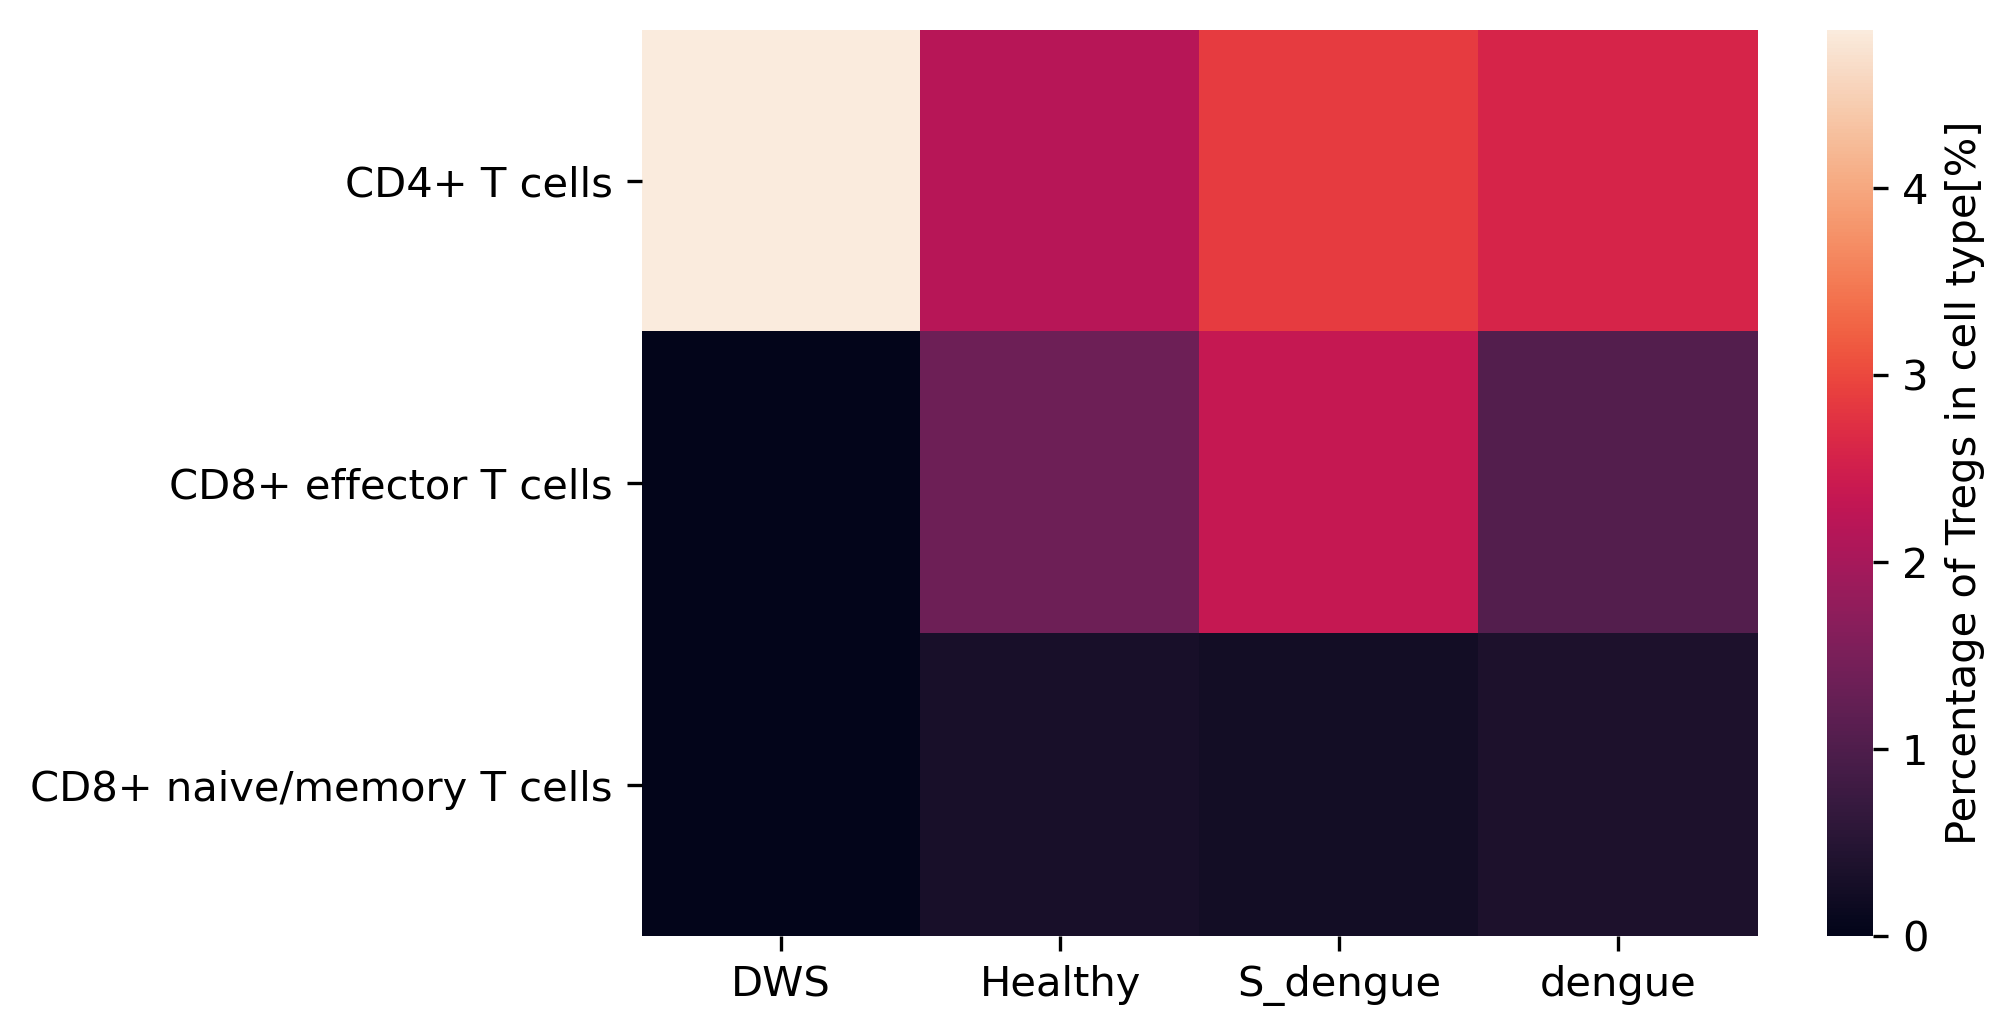

In [98]:
fig, ax = plt.subplots(dpi=300)
sns.heatmap(treg, ax=ax, cbar_kws={'label': 'Percentage of Tregs in cell type[%]'})
ax.set_xlabel(None)
ax.set_ylabel(None)

# log2foldchange between Treg and bystanders at different conditions


In [102]:
import anndataks

csts = ['CD4+ T cells', 'CD8+ effector T cells']

results = {}
for cst in csts:
    adata_ct = adata_kid[adata_kid.obs['cell_subtype_new'] == cst]
        
    adata_SD = adata_ct[adata_ct.obs['Treg'] == 'yes']
    adata_D = adata_ct[adata_ct.obs['Treg'] == 'no']
    # while calculating ks test pvalue, the adata is log1ped, so the argument log1p=2
    results[cst] = anndataks.compare(adata_D, adata_SD, log1p=2, mode='asymp') # log2_fold_change: adata_Sd vs adata_D

ks_res = pd.DataFrame([])
for cst in csts:
    results[cst]['cell_subtype'] = [cst] * results[cst].shape[0]
    ks_res = pd.concat([ks_res, results[cst]])

ks_res.set_index(['cell_subtype', ks_res.index], inplace=True)
ks_res.to_csv(save_tabels + 'ks_pvalue_treg_bystanders.tsv', sep='\t')

In [200]:
import anndataks

csts = ['CD4+ T cells', 'CD8+ effector T cells', 'CD8+ naive/memory T cells']
adata_SD = adata_kid[adata_kid.obs['Condition'] == 'S_dengue']

results = {}
for cst in csts:
    adata_ct = adata_SD[adata_SD.obs['cell_subtype_new'] == cst]
    adata_treg = adata_ct[adata_ct.obs['Treg'] == 'yes']
    adata_ctl = adata_ct[adata_ct.obs['Treg'] == 'no']
    # while calculating ks test pvalue, the adata is log1ped, so the argument log1p=2
    results[cst] = anndataks.compare(adata_ctl, adata_treg, log1p=2, mode='asymp') # log2_fold_change: adata_Sd vs adata_D

ks_res = pd.DataFrame([])
for cst in csts:
    results[cst]['cell_subtype'] = [cst] * results[cst].shape[0]
    ks_res = pd.concat([ks_res, results[cst]])

ks_res.set_index(['cell_subtype', ks_res.index], inplace=True)
ks_res.to_csv(save_tabels + 'ks_pvalue_treg_sd_bystanders.tsv', sep='\t')

# log2foldchange between SD and D

In [95]:
import anndataks

csts = ['CD4+ T cells', 'CD8+ effector T cells', 'CD8+ naive/memory T cells']
conditions = ['S_dengue', 'dengue']
adata_treg = adata_kid[adata_kid.obs['Treg'] == 'yes']

results = {}
for cst in csts:
    adata_ct = adata_treg[adata_treg.obs['cell_subtype_new'] == cst]
        
    adata_SD = adata_ct[adata_ct.obs['Condition'] == 'S_dengue']
    adata_D = adata_ct[adata_ct.obs['Condition'] == 'dengue']
    # while calculating ks test pvalue, the adata is log1ped, so the argument log1p=2
    results[cst] = anndataks.compare(adata_D, adata_SD, log1p=2, mode='asymp') # log2_fold_change: adata_Sd vs adata_D

ks_res = pd.DataFrame([])
for cst in csts:
    results[cst]['cell_subtype'] = [cst] * results[cst].shape[0]
    ks_res = pd.concat([ks_res, results[cst]])

ks_res.set_index(['cell_subtype', ks_res.index], inplace=True)
ks_res.to_csv(save_tabels + 'ks_pvalue_treg_sd_d.tsv', sep='\t')

In [11]:
ks_treg_by = pd.read_csv(save_tabels + 'ks_pvalue_treg_bystanders.tsv', sep='\t', index_col=['gene', 'cell_subtype'])
ks_treg_sd_by = pd.read_csv(save_tabels + 'ks_pvalue_treg_sd_bystanders.tsv', sep='\t', index_col=['gene', 'cell_subtype'])

In [12]:
ks_treg_sd = pd.read_csv(save_tabels + 'ks_pvalue_treg_sd_d.tsv', sep='\t', index_col=['gene', 'cell_subtype'])

In [17]:
def pairwise_processing(df_kid, df_adult):
    ###### merge two df
    intersect = [x for x in df_kid.index if x in df_adult.index]
    df_adult.columns = [col+'_a' for col in df_adult.columns]
    df = pd.concat([df_kid.loc[intersect], df_adult.loc[intersect]], axis=1)
    
    ###### define robost genes for kids, adults or both
    ind_kid = df[(df['fra_pair'] >= 39/56) | (df['neg_fra_pair'] >= 39/56)].index
    ind_adult = df[(df['fra_pair_a'] >= 39/56) | (df['neg_fra_pair_a'] >= 39/56)].index
    ind_merge = list(set(ind_kid) & set(ind_adult))
    
    df['outlier'] = 'no'
    df.loc[ind_kid, 'outlier'] = 'x_only'
    df.loc[ind_adult, 'outlier'] = 'y_only'
    df.loc[ind_merge, 'outlier'] = 'both'
    
    ###### calculate marker and distance
    df['x'] = df['med_pair'] - df['med_pair'].mean()
    df['y'] = df['med_pair_a'] - df['med_pair_a'].mean()
    df['r'] = np.sqrt(df['x'] ** 2 + df['y'] ** 2)
    
    ###### set markers for genes
    df_2 = df[df['r'] >= df['r'].quantile(q = 0.95)] 
    r = df_2.sort_values('r').iloc[0]['r']

    df['markers'] = 'no'
        
    df.loc[df_2[(df_2['x'] > 1) & (df_2['y'] > 1)].index, 'markers'] = '1'
    df.loc[df_2[(df_2['x'] < -1) & (df_2['y'] > 1)].index, 'markers'] = '2'
    df.loc[df_2[(df_2['x'] < -1) & (df_2['y'] < -1)].index, 'markers'] = '3'
    df.loc[df_2[(df_2['x'] > 1) & (df_2['y'] < -1)].index, 'markers'] = '4'

    df.loc[df_2[(df_2['x'] > 1) & (df_2['y'] < 1) & (df_2['y'] > -1)].index, 'markers'] = '5'
    df.loc[df_2[(df_2['y'] > 1) & (df_2['x'] < 1) & (df_2['x'] > -1)].index, 'markers'] = '6'
    df.loc[df_2[(df_2['x'] < -1) & (df_2['y'] < 1) & (df_2['y'] > -1)].index, 'markers'] = '7'
    df.loc[df_2[(df_2['y'] < -1) & (df_2['x'] < 1) & (df_2['x'] > -1)].index, 'markers'] = '8'
    return (df, r)

In [16]:
ks_treg_sd_by.sort_values('log2_fold_change')

,,statistic,pvalue,avg1,avg2,log2_fold_change
gene,cell_subtype,,,,,
SELL,CD8+ naive/memory T cells,0.799035,0.016233,7.930878,2.271452,-5.659425
UBE2D3,CD8+ naive/memory T cells,0.583601,0.168558,5.303910,0.000000,-5.303910
CCR7,CD8+ naive/memory T cells,0.553859,0.219891,5.156248,0.000000,-5.156248
CD3D,CD8+ naive/memory T cells,0.503483,0.325254,8.234111,3.267699,-4.966412
NDFIP1,CD8+ naive/memory T cells,0.538585,0.249486,4.897444,0.000000,-4.897444
...,...,...,...,...,...,...
OSGEP,CD8+ naive/memory T cells,0.897106,0.002179,0.882203,8.093075,7.210872
GART,CD8+ naive/memory T cells,0.915595,0.001203,0.835737,8.424267,7.588530
CEP68,CD8+ naive/memory T cells,0.943730,0.000356,0.486693,8.093075,7.606381


In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
    
sns.scatterplot(data=df, x='med_pair', y='med_pair_a', ax=ax, hue='markers', 
                 hue_order=['1', '2', '3', '4', '5', '6', '7', '8', 'no'],
                 palette=sns.color_palette('hls',8) + ['gray'], 
                 edgecolor='none', s=3)
sns.set_style('ticks')

mark_list = marklist
for gene in mark_list:
    ax.text(df.loc[gene, 'med_pair']-0.6, 
    df.loc[gene, 'med_pair_a'] + 0.005,
    gene, color = 'black',
    fontsize = 4)

ax.set_xlim(-xlim, xlim)
ax.set_ylim(-xlim, xlim)

# Draw 8 slices using Fabio's function 
x_mean = df['med_pair'].mean()
y_mean = df['med_pair_a'].mean()
center = (x_mean, y_mean)

if r >= 1:
    draw_8_slices(ax, center, radius=r)
else:
    draw_8_slices(ax, center, radius=1)

#draw_8_slices(ax, center, radius=r)
ax.set_xlabel('XCL low NK cells', fontsize=10)
ax.set_ylabel('XCL high NK cells', fontsize=10)

ax.set_title('Median log2 fold change of \npairwise comparison (SD vs D)', fontsize=10)
ax.get_legend().remove()

ticklabels = range(-int(xlim), int(xlim)+1, 2)
ax.set_xticks(ticklabels)
ax.set_yticks(ticklabels)
ax.set_xticklabels(ticklabels, fontsize=10)
ax.set_yticklabels(ticklabels, fontsize=10)


# fraction of expression and mean expression of Tregs at different conditions

In [110]:
fra = pd.DataFrame([])
avg = pd.DataFrame([])

cds = ['S_dengue', 'dengue', 'Healthy', 'DWS']
p_ID = 'ID'
log1p == 2

adata_treg = adata_kid[adata_kid.obs['Treg'] == 'yes']

adata_cd = {cd: (adata_treg[adata_treg.obs['Condition'] == cd]) for cd in cds}

for cell_type in ['CD4+ T cells', 'CD8+ effector T cells', 'CD8+ naive/memory T cells']:
    ct_obs = 'cell_subtype_new'

    for cd in cds:
        adata_ct = adata_cd[cd][adata_cd[cd].obs[ct_obs] == cell_type]

        if adata_ct.obs.shape[0] == 0:
            continue
        fra_ct = np.asarray((adata_ct.X > 0).mean(axis=0))[0]
        fra_ct = pd.DataFrame(fra_ct, columns=['fra'], index=adata_ct.var_names)
        fra_ct[ct_obs] = cell_type
        fra_ct['condition'] = cd
        fra = pd.concat([fra, fra_ct])
        fra['gene'] = fra.index.tolist()

        avg_ct = np.asarray(adata_ct.X.mean(axis=0))[0]

        if log1p == 2:
            avg_ct = np.exp2(avg_ct) -1

        avg_ct = pd.DataFrame(avg_ct, columns=['avg'], index=adata_ct.var_names)
        avg_ct[ct_obs] = cell_type
        avg_ct['condition'] = cd
        avg = pd.concat([avg, avg_ct])
        avg['gene'] = avg.index.tolist()
avg.to_csv(save_tabels + 'Treg_avg_cds.tsv', sep='\t', index=False)
fra.to_csv(save_tabels + 'Treg_fra_cds.tsv', sep='\t', index=False)

In [64]:
avg = pd.read_csv(save_tabels + 'Treg_avg_cds.tsv', sep='\t', index_col=['cell_subtype_new', 'gene', 'condition'])
fra = pd.read_csv(save_tabels + 'Treg_fra_cds.tsv', sep='\t', index_col=['cell_subtype_new', 'gene', 'condition'])

# cytokines released by Tregs 

In [66]:
'''
'IL10',
'IL12A', 'EBI3', # IL35
'TGFB1'
'''

"\n'IL10',\n'IL12A', 'EBI3', # IL35\n'TGFB1'\n"

In [117]:
def heatmap_cst(ks_treg_sd, g_list, title, vs_type='SD vs D', save_fd=False):
    
    df = ks_treg_sd.reset_index().set_index('gene').loc[g_list][['cell_subtype', 'log2_fold_change']]

    cst_order=['CD4+ T cells',
               'CD8+ effector T cells',
               'CD8+ naive/memory T cells',
                 ]

    df_new = pd.DataFrame(np.zeros([len(df.index.unique()), 3]), columns=cst_order, index=df.index.unique())

    for idx in df_new.index:    
        for col in df_new.columns:
            df_new.at[idx, col] = df.loc[idx][df.loc[idx]['cell_subtype'] == col]['log2_fold_change'][0]

    fig, ax = plt.subplots(figsize=[0.5 * len(g_list), 1.5], dpi=300)
    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    ax = sns.heatmap(df_new.T, cmap=cmap, center=0, yticklabels=True,
                     cbar_kws={'label': 'Log2 fold change\n[%s]'%vs_type})
    ax.set_title(title, x=0.5, y=1.05)
    ax.set_xlabel(None)
    ylabels = [label.get_text().replace('T cells', 'Tregs') for label in ax.get_yticklabels()]
    ax.set_yticklabels(ylabels)

    if save_fd is not False:
        fig.savefig(save_figures + save_fd, bbox_inches='tight')

    return {'figure': fig, 'ax': ax}

{'figure': <Figure size 1500x450 with 2 Axes>,
 'ax': <AxesSubplot:title={'center':'Suppressive genes in Tregs'}>}

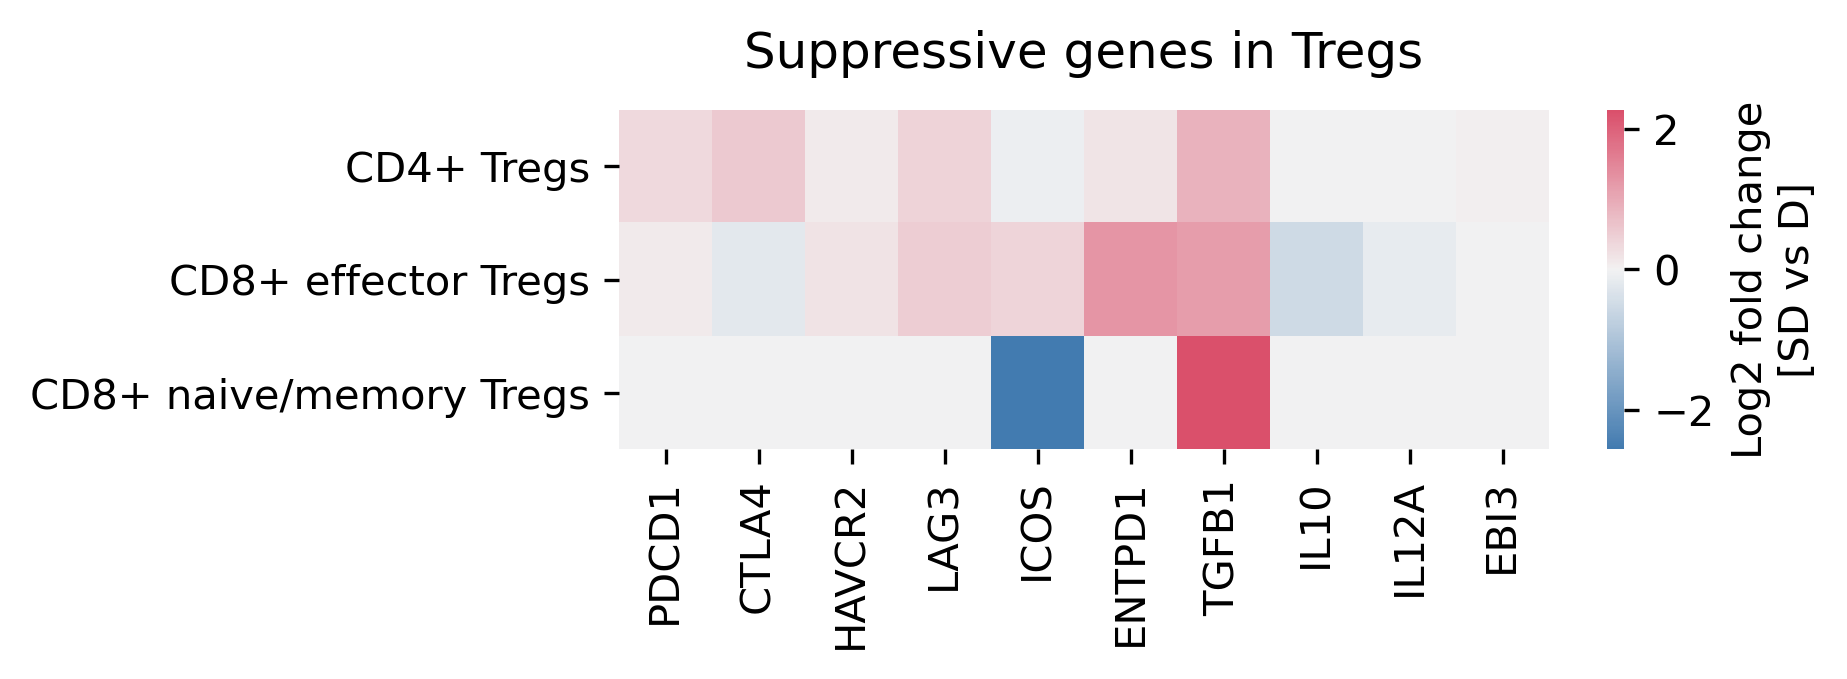

In [118]:
treg_genes = ['PDCD1', 'CTLA4', 'HAVCR2',  'LAG3', 'ICOS', 'ENTPD1', 'TGFB1','IL10', 'IL12A', 'EBI3'] # 'IL2RA', 'FOXP3', 
heatmap_cst(ks_treg_sd, treg_genes, 'Suppressive genes in Tregs', save_fd='Tregs/Treg_genes_SD_vs_D.png')

{'figure': <Figure size 1500x450 with 2 Axes>,
 'ax': <AxesSubplot:title={'center':'Suppressive genes in Tregs'}>}

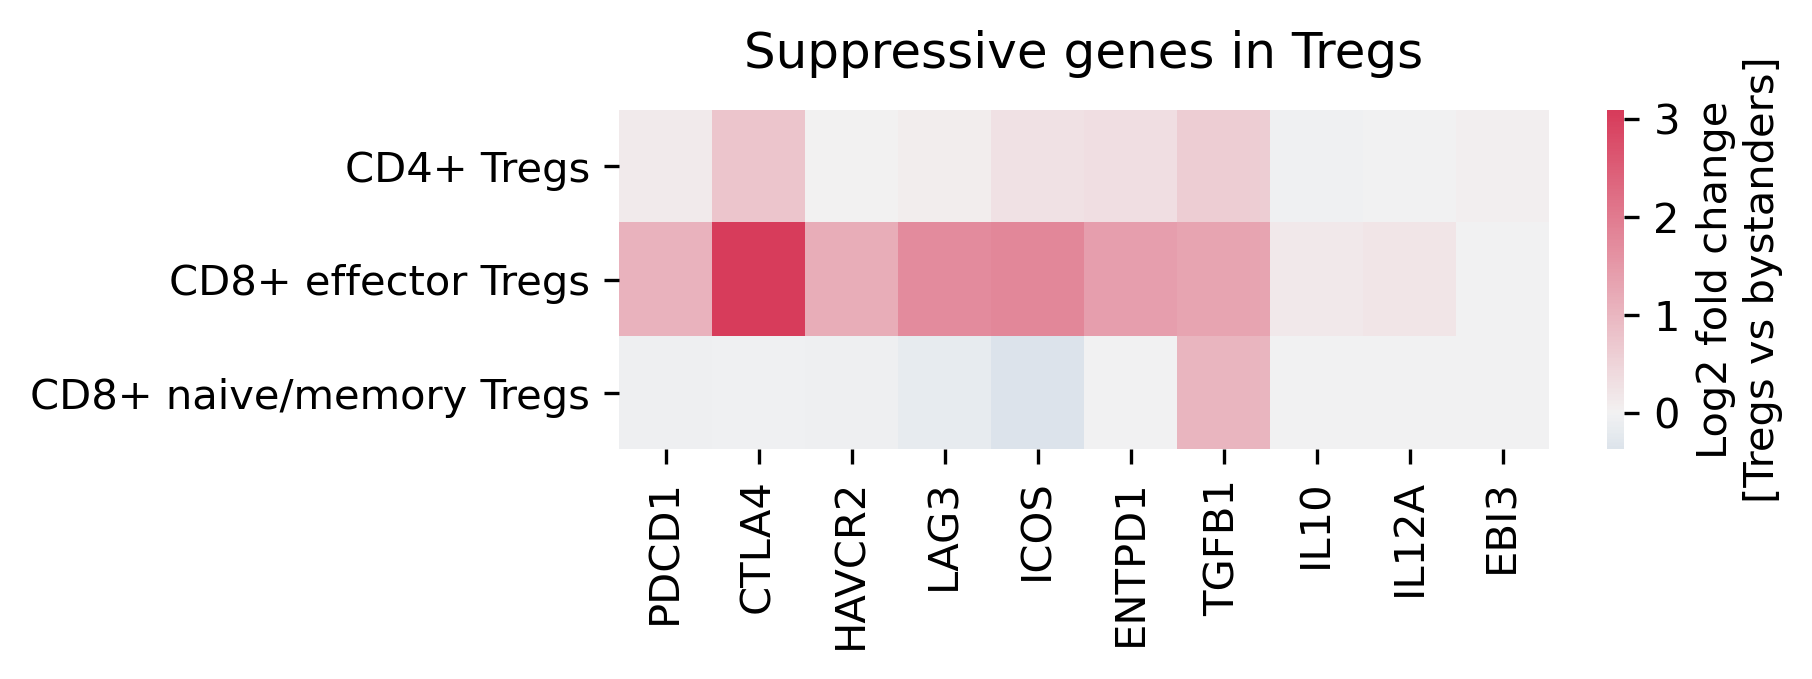

In [119]:
heatmap_cst(ks_treg_sd_by, treg_genes, 'Suppressive genes in Tregs', vs_type='Tregs vs bystanders', save_fd='Tregs/Treg_genes_in_SD_vs_bystanders.png')

# Treg attracting chemokines

{'figure': <Figure size 3300x450 with 2 Axes>,
 'ax': <AxesSubplot:title={'center':'CCL17 & CCL22 receptors'}>}

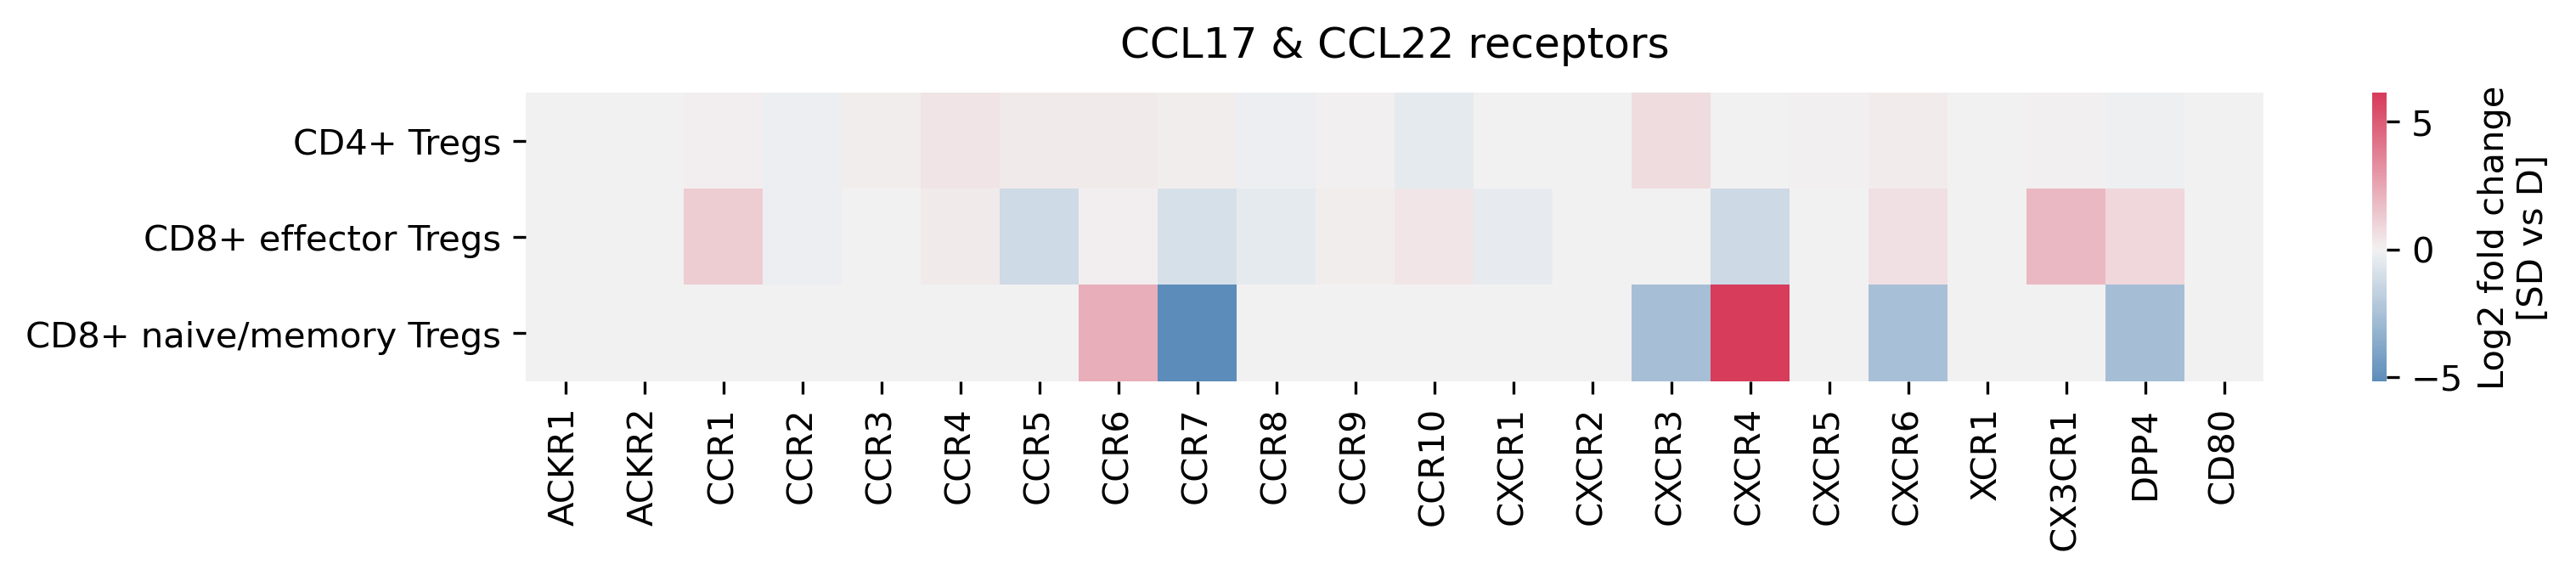

In [120]:
# 'CCL17' and 'CCL22' are paralogs
# 'CCR4', 'CCR8'
treg_receptors = ['ACKR1', 'ACKR2', 
           'CCR1',  'CCR2', 'CCR3', 'CCR4', 'CCR5', 'CCR6', 'CCR7', 'CCR8', 'CCR9', 'CCR10',
           'CXCR1', 'CXCR2', 'CXCR3', 'CXCR4', 'CXCR5', 'CXCR6',
           'XCR1', 
           'CX3CR1', 
           'DPP4', 'CD80',]  # 'DPP4' & 'CD80' specific for 'CCL22'
heatmap_cst(ks_treg_sd, treg_receptors, 'CCL17 & CCL22 receptors', save_fd='Tregs/Treg_receptors_SD_vs_D.png')

{'figure': <Figure size 3300x450 with 2 Axes>,
 'ax': <AxesSubplot:title={'center':'CCL17 & CCL22 receptors in SD'}>}

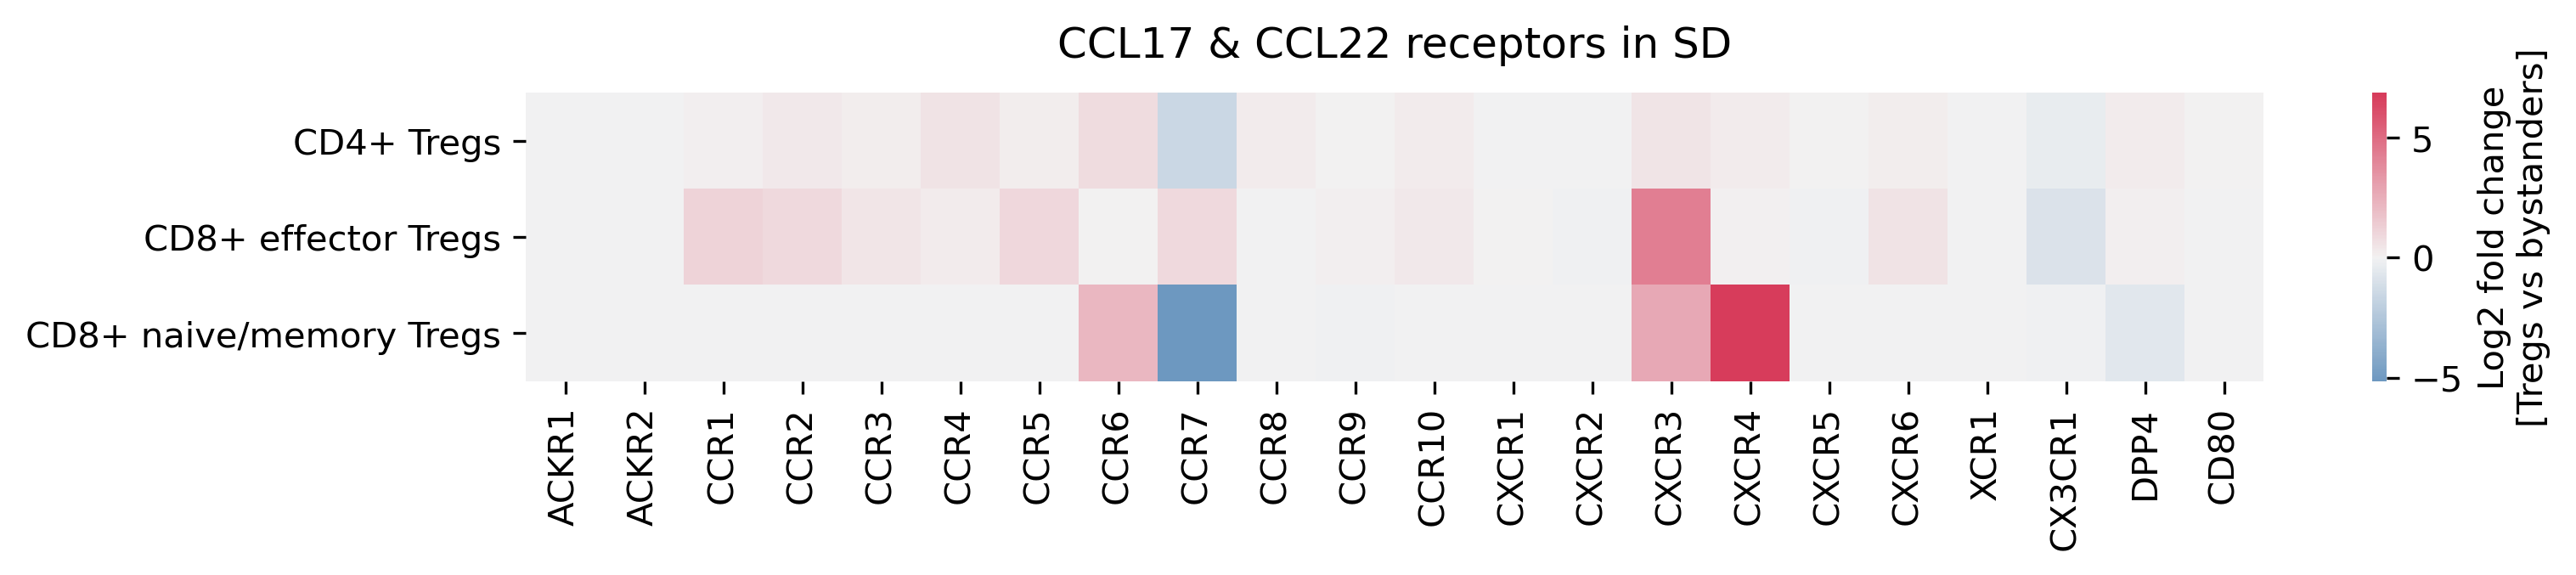

In [85]:
heatmap_cst(ks_treg_sd_by, treg_receptors, 'CCL17 & CCL22 receptors in SD', vs_type='Tregs vs bystanders', save_fd='Tregs/Treg_receptors_in_SD_vs_bystanders.png')

# interactions related with Tregs

In [224]:
# receptors of Treg attracting chemokines CCL17, CCL22
CCL17 = np.unique(interactions[(interactions['genesymbol_intercell_source'].isin(['CCL17'])) | (interactions['genesymbol_intercell_target'].isin(['CCL17']))])
CCL22 = np.unique(interactions[(interactions['genesymbol_intercell_source'].isin(['CCL22'])) | (interactions['genesymbol_intercell_target'].isin(['CCL22']))])
CCL17_receptors = set(CCL17) - set(['CCL17'])
CCL22_receptors = set(CCL22) - set(['CCL22'])
treg_receptors = set(CCL17_receptors) | set(CCL22_receptors)
CCL17_spe = set(CCL17_receptors) - set(CCL22_receptors)
CCL22_spe = set(CCL22_receptors) - set(CCL17_receptors)

In [8]:
def it_genes(gene):
    all_genes = np.unique(interactions[(interactions['genesymbol_intercell_source'].isin(gene))
                                       | (interactions['genesymbol_intercell_target'].isin(gene))])
    it_genes = set(all_genes) - set(gene)
    return it_genes

In [21]:
treg_genes = ['PDCD1', 'HAVCR2', 'CTLA4', 'LAG3', 'ICOS', 'ENTPD1', 'IL2RA', 'TGFB1','IL10', 'IL12A', 'EBI3', 'TIGIT']
for gene in treg_genes:
    print(gene + ':')
    print(it_genes([gene]))

PDCD1:
{'PDCD1LG2', 'FAM3C', 'BMP4', 'IFNA1', 'CD274'}
HAVCR2:
{'LGALS9'}
CTLA4:
{'FYN', 'CD86', 'ICOSLG', 'CD80'}
LAG3:
{'SNCA', 'FGL1', 'LGALS3'}
ICOS:
{'CD40LG', 'ICOSLG', 'TNF'}
ENTPD1:
{'ADORA3', 'ADORA1', 'ADORA2A', 'ADORA2B'}
IL2RA:
{'ICAM1', 'CD8B', 'CD8A', 'PTPN6', 'IL4', 'IL15', 'IL1RN', 'HLA-A', 'IL2'}
TGFB1:
{'COMPLEX:ACVR1C_TGFBR2', 'COMPLEX:ITGAV_ITGB3', 'INHBB', 'MRGPRX3', 'BMP3', 'PTGER2', 'ITGB3', 'CD28', 'SDC1', 'COMPLEX:ITGAV_ITGB1', 'COMPLEX:TGFBR1_TGFBR2', 'ITGB1', 'CD8A', 'VEGFA', 'ACVRL1', 'IL7', 'ADCYAP1', 'INHBA', 'IFNG', 'IL2', 'DCN', 'COMPLEX:ITGAV_ITGB6', 'F2RL1', 'DPP4', 'TGFBR1', 'PPARG', 'F3', 'IL4', 'COMPLEX:ACVR1_TGFBR1_TGFBR2', 'SFTPA1', 'TNF', 'SFTPA2', 'TGFB2', 'IL13', 'TLR2', 'CXCL12', 'PLAU', 'HGF', 'EDN1', 'UTS2', 'IL17A', 'AVP', 'ITGB6', 'RB1', 'COMPLEX:ACVR1_TGFBR2', 'TNFRSF11B', 'IL1RN', 'PTN', 'YBX1', 'LEFTY1', 'GLG1', 'FGF13', 'INHBE', 'ERBB2', 'THBS1', 'PLG', 'CD109', 'MET', 'EGF', 'COMPLEX:ACVR1B_TGFBR2', 'KLRK1', 'TGFBR2', 'INHBC', 'COMPLE

# Treg mushrooms

In [79]:
def Treg_mushrooms(genes, vmax=3):
    '''
    genes = [{'ITGAX': ['B_cells', 'NK_cells'],
          'ITGB2': ['cDCs'],
          'ICAM1': ['Plasmablasts']},
         {'CCL4L2': ['Monocytes'], 'VSIR': ['pDCs']}]
    '''
    from matplotlib.patches import Wedge
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import math
    import numpy as np
    import pandas as pd
    import itertools

    #save_tabels = '/home/yike/phd/dengue/data/tables/dataset_20211001/'

    conditions = ['S_dengue', 'dengue']
    cmap = plt.cm.get_cmap('viridis')
    vmin = -1
    threshold = 0.05
    frac_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/dataset_20211001/' + 'Treg_fra_cds.tsv', 
                         sep='\t', index_col=['cell_subtype_new', 'condition', 'gene'], squeeze=True)
    avg_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/dataset_20211001/' + 'Treg_avg_cds.tsv', 
                         sep='\t', index_col=['cell_subtype_new', 'condition', 'gene'], squeeze=True)

    yl = sum([len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes])
    fig = plt.figure(figsize=((1 + 0.8 * 2) * 0.6, (1 + yl)* 0.6), dpi=300)

    grid = plt.GridSpec(yl , 2, wspace=0.1, hspace=0.1)
    
    axs = []
    for i in range(len(genes)):
         axs.append(plt.subplot(grid[sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i]): sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i+1]), 0: 1]))
    size_bar = plt.subplot(grid[0: 5, 1: 2])

    datap = []
    for genesi, ax in zip(genes, axs):
        cts = list(genesi.values())
        gs = list(genesi.keys())
        yticklabels = []
        for i, (csts, gene) in enumerate(zip(cts, gs)):
            for cst in csts:
                avgs = []
                yticklabels.append(cst.replace('T cells', 'Tregs'))
                for k, cond in enumerate(conditions):
                    fr = frac_ct.loc[(cst, cond, gene)]
                    av = np.log10(avg_ct.loc[(cst, cond, gene)] + 0.1)
                    avgs.append(av)
                    r = 0.5 * fr**0.3
                    color = cmap((min(vmax, av) - vmin) / (vmax - vmin))
                    theta0, theta1 = 180 * (k > 0), 180 + 180 * (k > 0)
                    datap.append({
                        'r': r,
                        'facecolor': color,
                        'center': (0, len(yticklabels)-1),
                        'theta': (theta0, theta1),
                        'ax': ax,
                    })
                if avgs[0] - avgs[1] > threshold:
                    datap[-2]['edgecolor'] = 'red'
                    datap[-1]['edgecolor'] = 'none'
                elif avgs[0] - avgs[1] < -threshold:
                    datap[-1]['edgecolor'] = 'red'
                    datap[-2]['edgecolor'] = 'none'
                else:
                    datap[-1]['edgecolor'] = 'none'
                    datap[-2]['edgecolor'] = 'none'   

        axs[0].set_title(gene)
        ax.set_yticks(np.arange(len(list(itertools.chain.from_iterable(genesi.values())))))
        ax.set_yticklabels(yticklabels)
        ax.set_ylim(-0.6, len(list(itertools.chain.from_iterable(genesi.values()))) - 0.4)        
        ax.set_xticks([])
        ax.set_xlim(-0.6, 1 - 0.4)

    for datum in datap:
        ax = datum['ax']
        r = datum['r']
        color = datum['facecolor']
        center = datum['center']
        theta0, theta1 = datum['theta']
        ec = datum['edgecolor']

        h = Wedge(
            center, r, theta0, theta1, facecolor=color, edgecolor=ec
        )
        ax.add_artist(h)
        ax.set_aspect(1)

    size_bar.set_ylim(-0.6, 5 - 0.4)        
    c = [(0.5, i) for i in range(5)]
    radius = [0.5 * fr**0.3 for fr in [0.05, 0.1, 0.2, 0.4, 0.8]]
    for c, r in zip(c, radius):
        e = Wedge(c, r, 0, 180, facecolor='gray',)
        size_bar.add_artist(e)
    size_bar.set_aspect(1)
    size_bar.set_yticks([])
    size_bar.set_yticks(range(5))
    size_bar.set_yticklabels(['5', '10', '20', '40', '80'])
    size_bar.yaxis.tick_right()
    size_bar.yaxis.set_label_position('right')
    size_bar.set_ylabel('Gene exp frac')
    size_bar.set_xticks([])
    size_bar.spines['bottom'].set_visible(False)
    size_bar.spines['top'].set_visible(False)
    size_bar.spines['right'].set_visible(False)
    size_bar.spines['left'].set_visible(False)

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax) 
    cmap = plt.cm.get_cmap('viridis')
    position = fig.add_axes([0.7, 0.2, 0.05, 2/yl])
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=position, ax=axs[-1], label='Gene exp \n(log10[cpm+0.1])')

    fig.tight_layout()
    
    return {'figure': fig, 'axs': ax}


<ipython-input-79-ef822fa27bbc>:34: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  axs.append(plt.subplot(grid[sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i]): sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i+1]), 0: 1]))
<ipython-input-79-ef822fa27bbc>:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


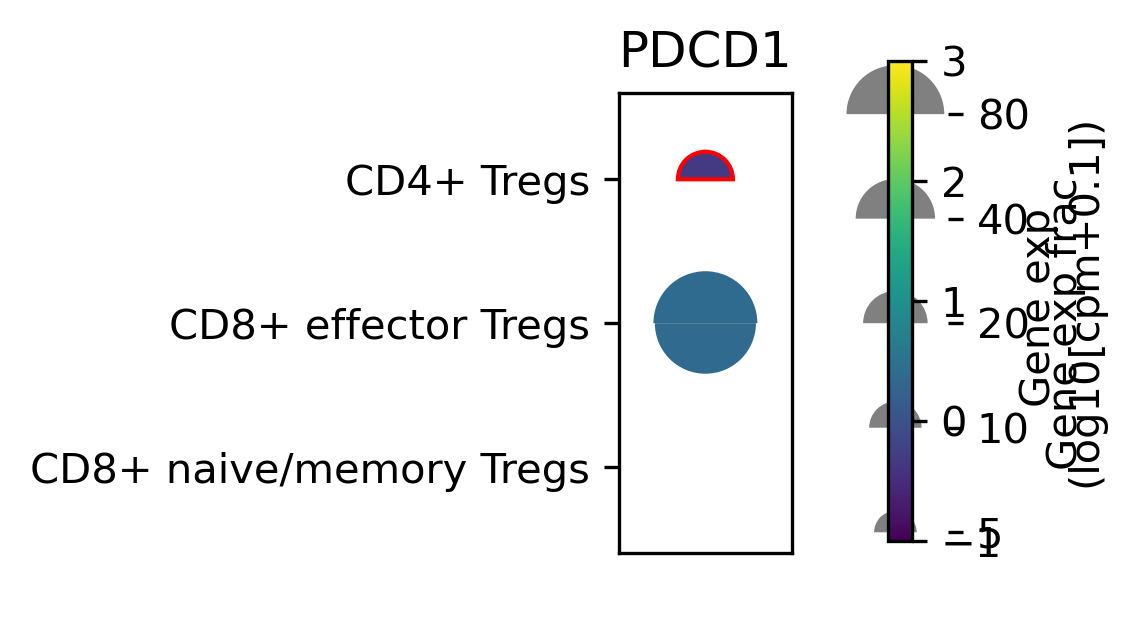

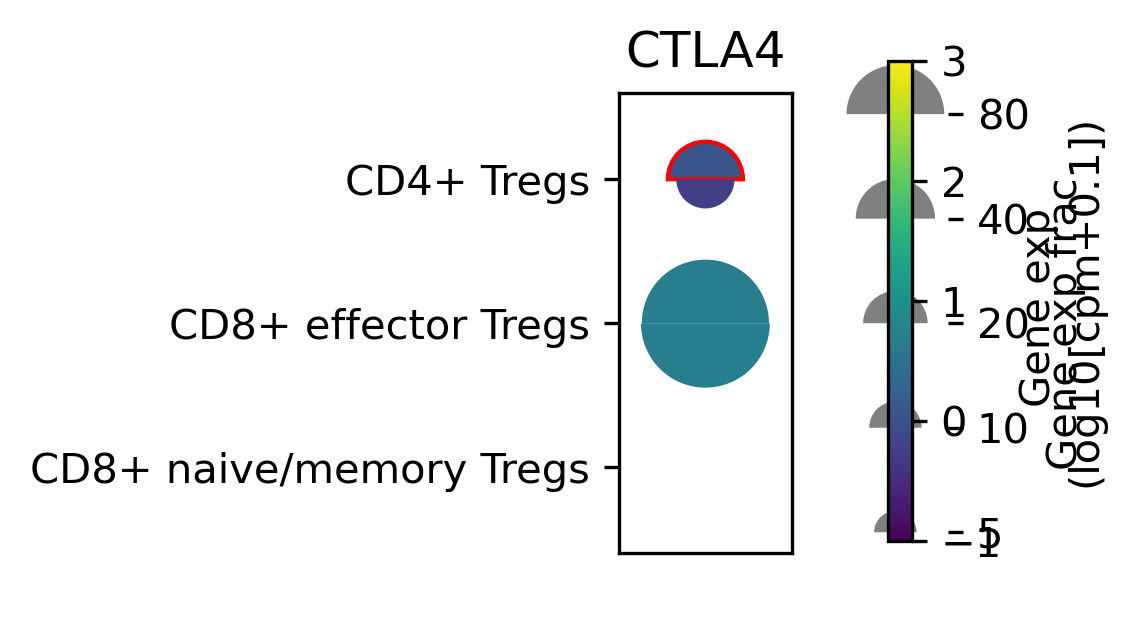

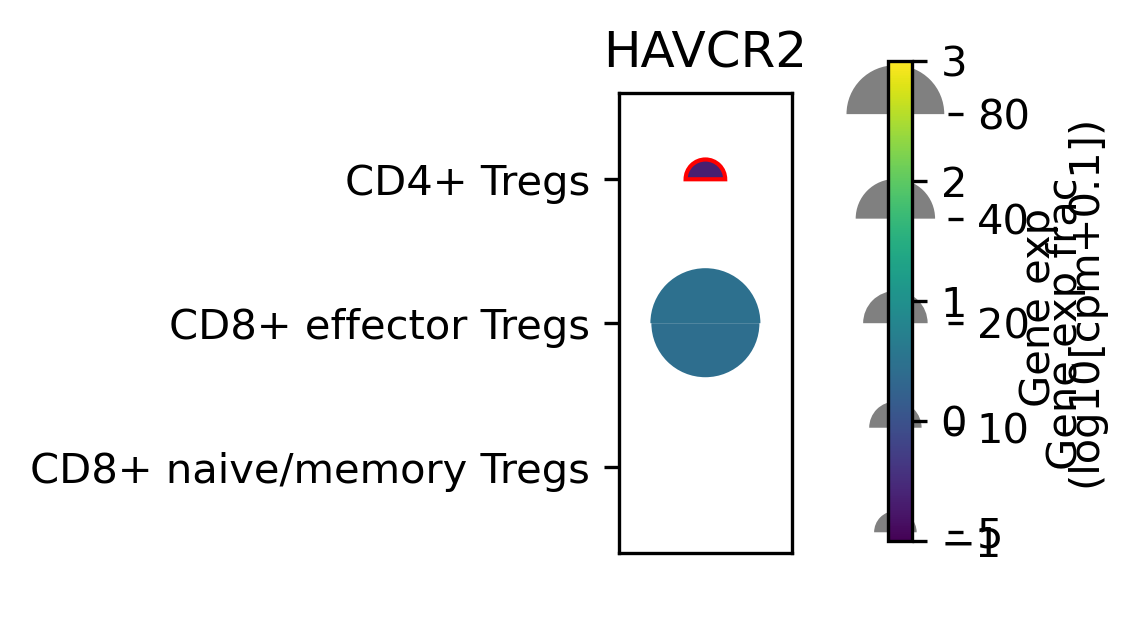

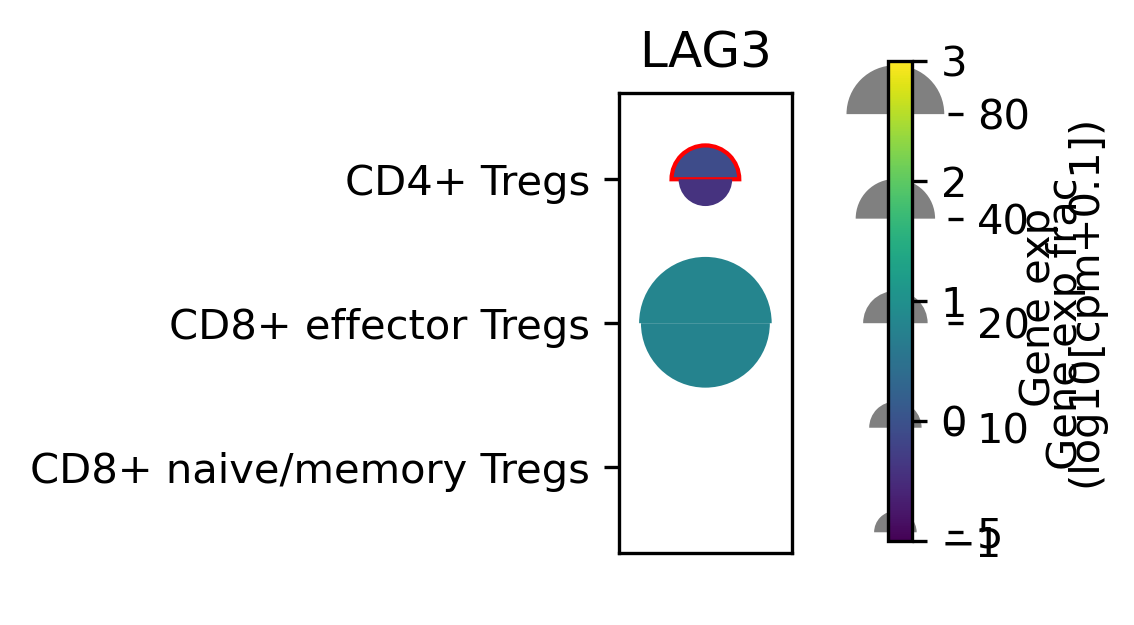

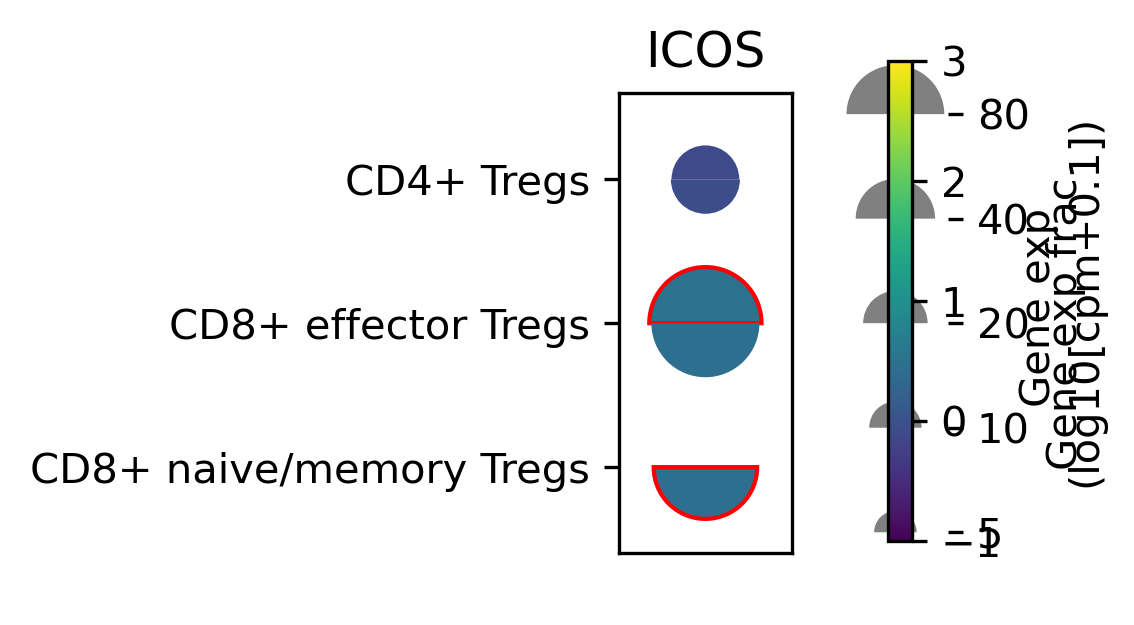

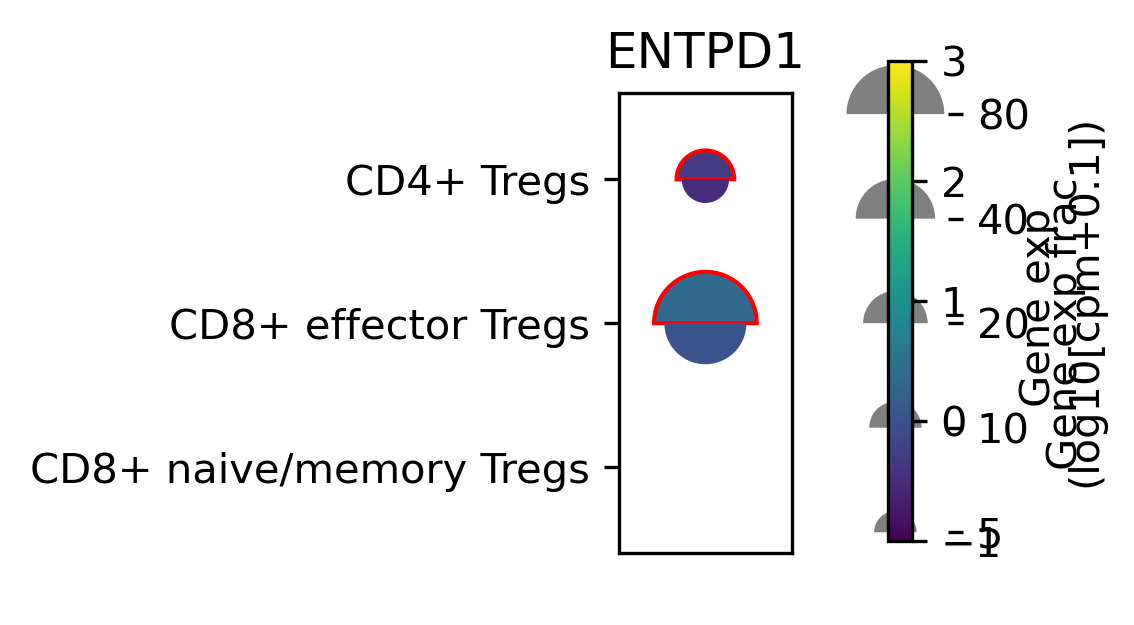

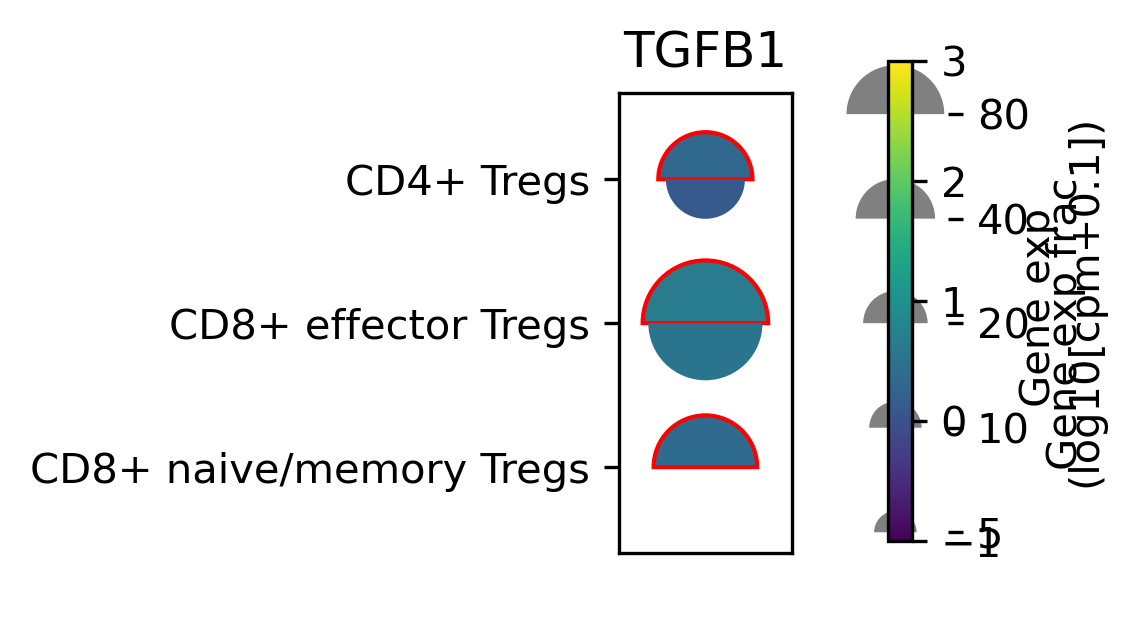

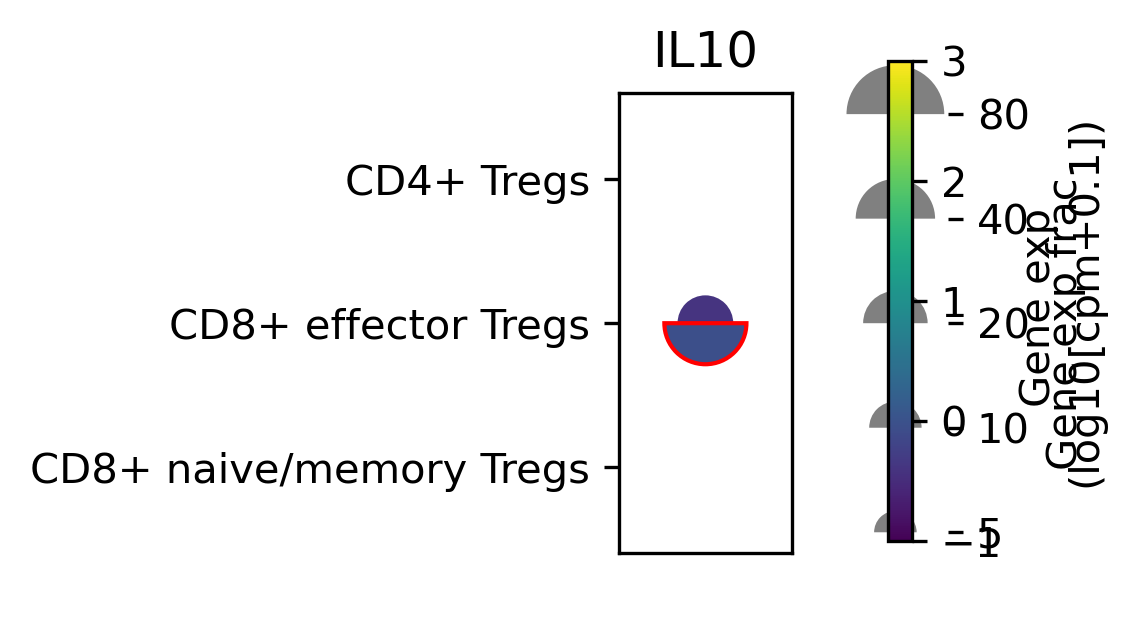

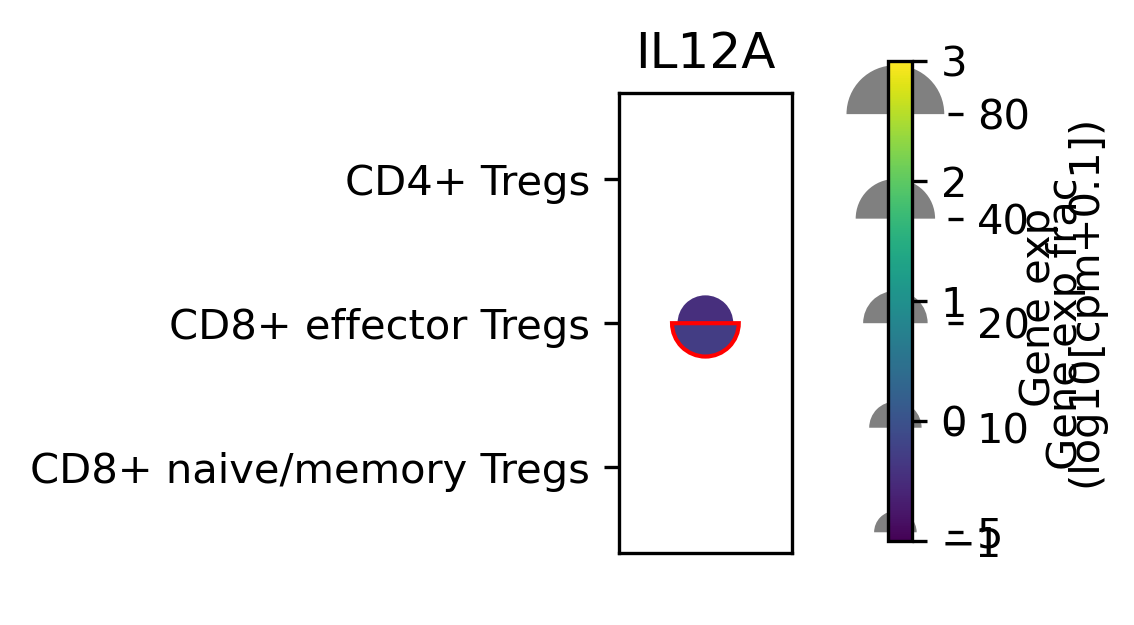

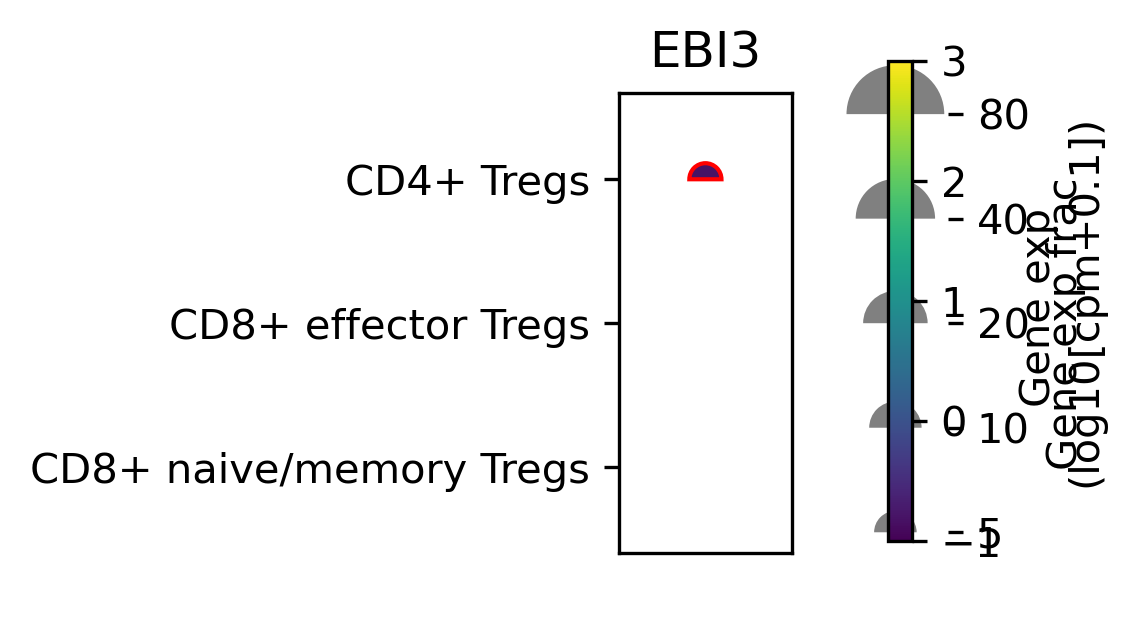

In [80]:
csts_plot = [  'CD4+ T cells',
               'CD8+ effector T cells',
               'CD8+ naive/memory T cells',
                 ]

csts_plot.reverse()

markers = ['PDCD1', 'CTLA4', 'HAVCR2',  'LAG3', 'ICOS', 'ENTPD1', 'TGFB1','IL10', 'IL12A', 'EBI3']

for gene in markers:
    g = Treg_mushrooms([{gene: csts_plot}])['figure']
    g.savefig(save_figures + 'Tregs/Suppressive_genes/' + gene + '.png', bbox_inches='tight')

<ipython-input-79-ef822fa27bbc>:34: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  axs.append(plt.subplot(grid[sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i]): sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i+1]), 0: 1]))
<ipython-input-79-ef822fa27bbc>:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
<ipython-input-79-ef822fa27bbc>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=((1 + 0.8 * 2) * 0.6, (1 + yl)* 0.6), dpi=300)


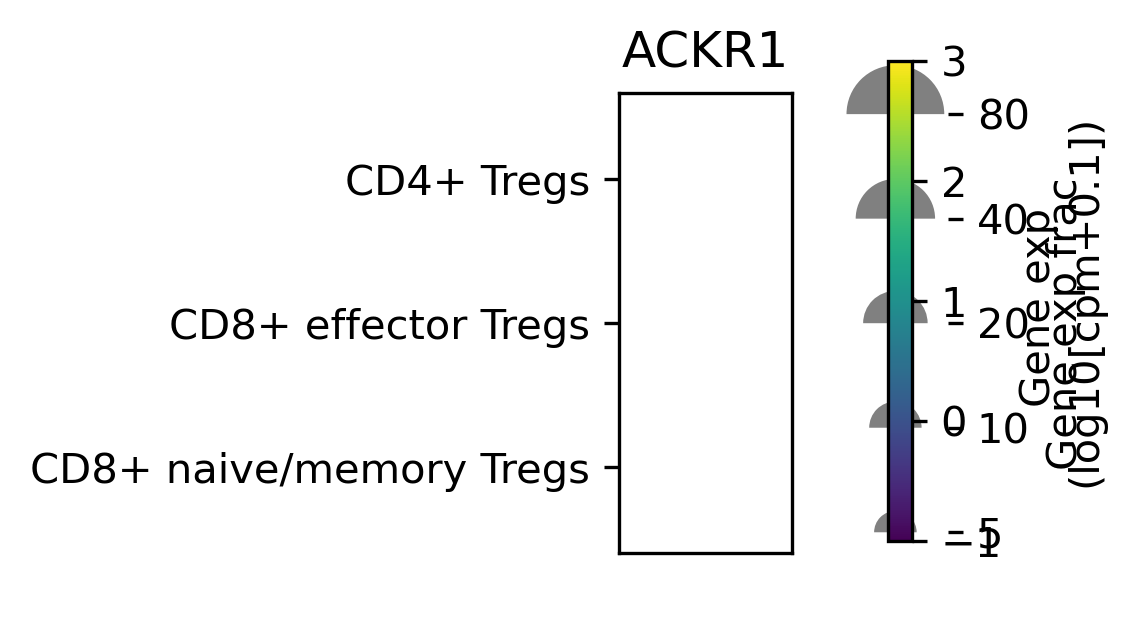

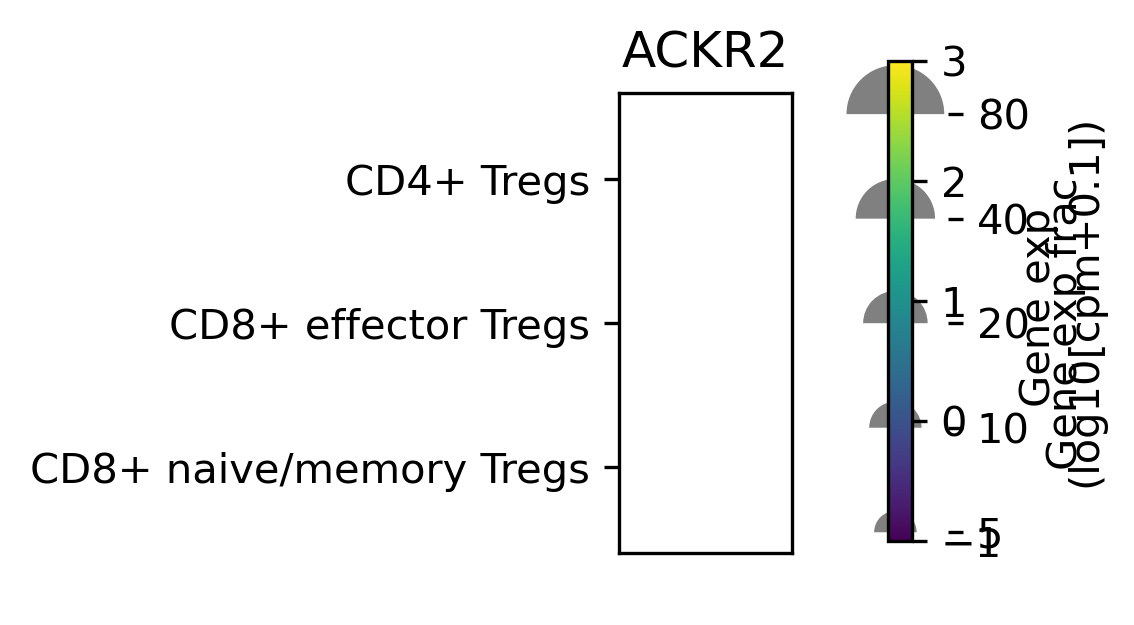

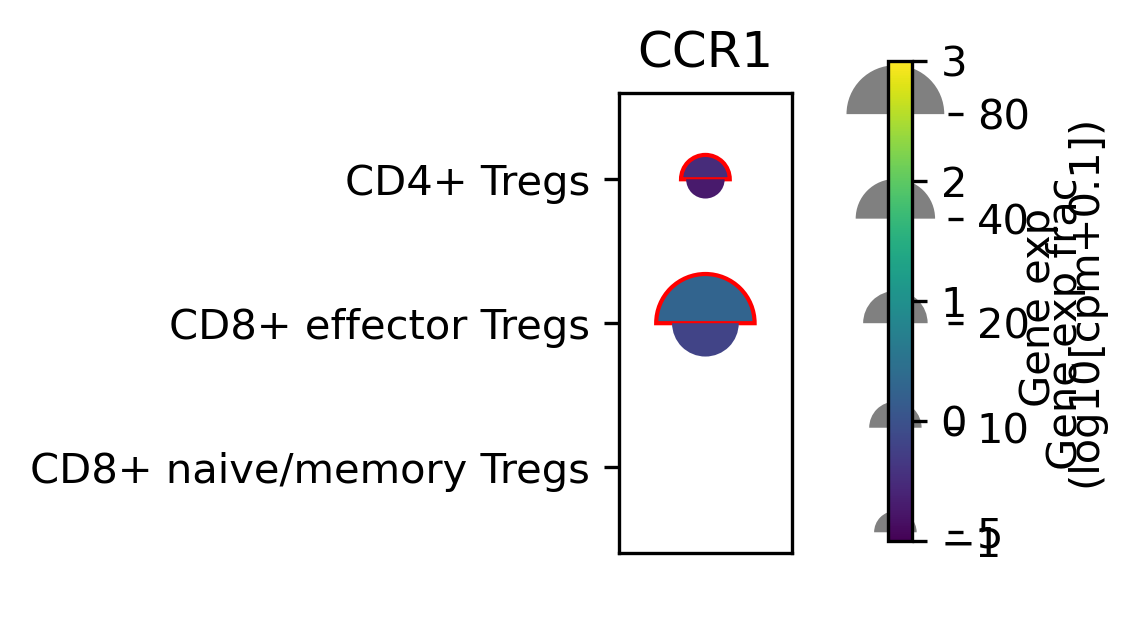

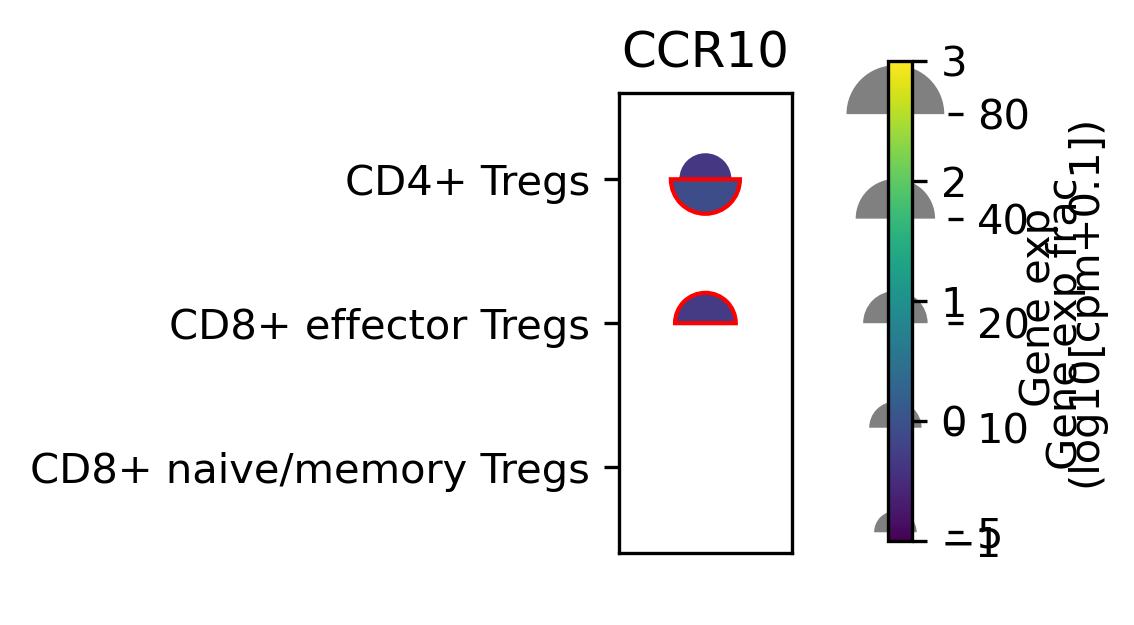

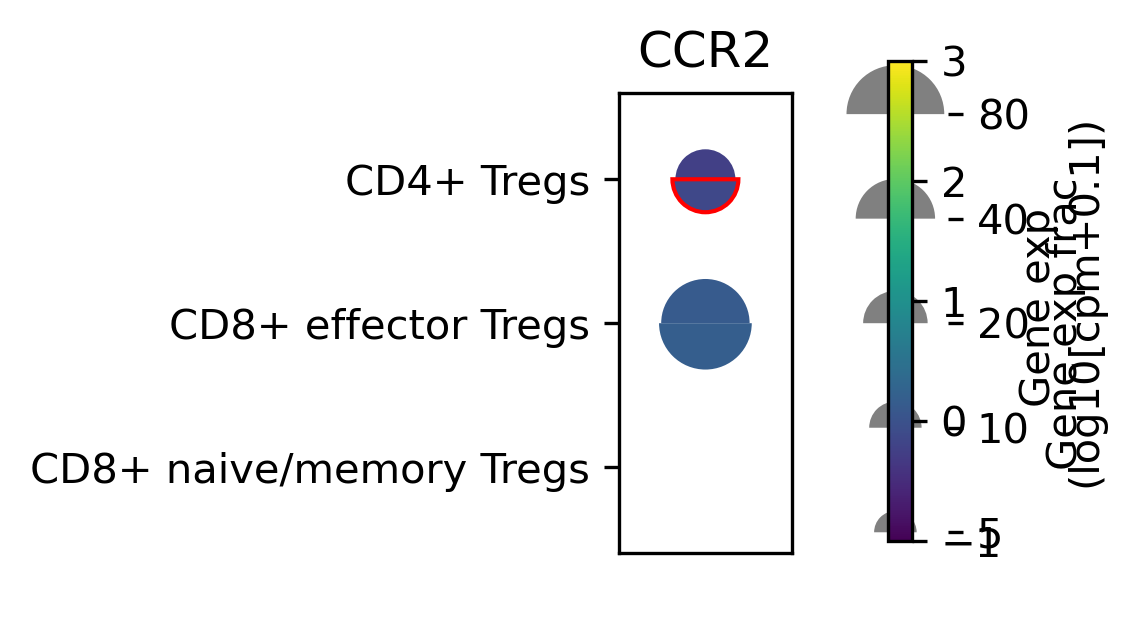

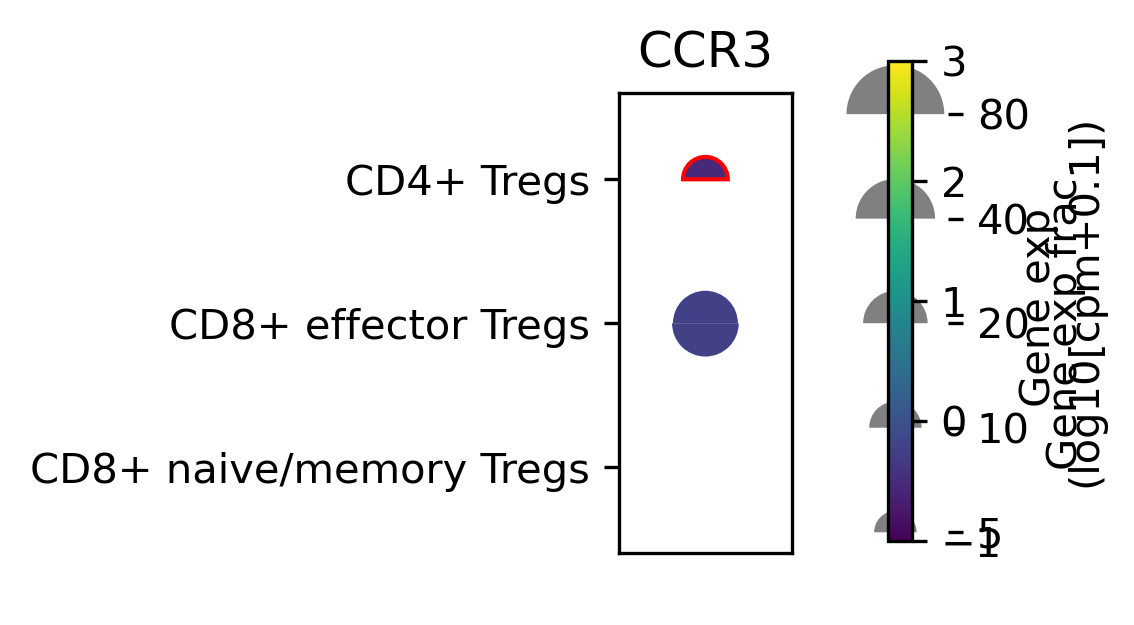

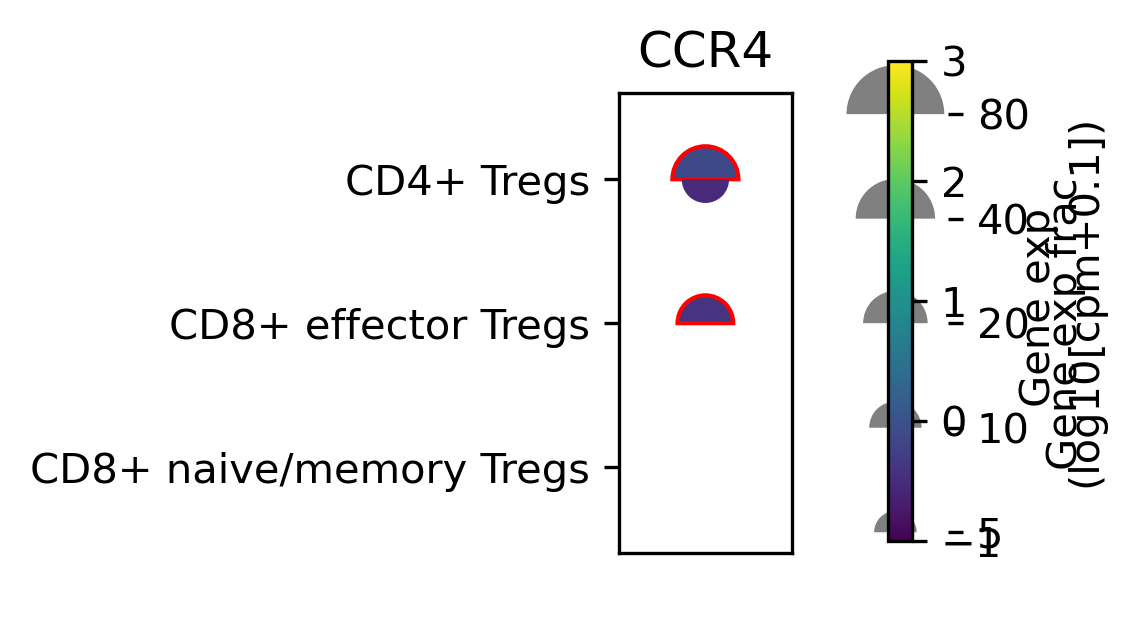

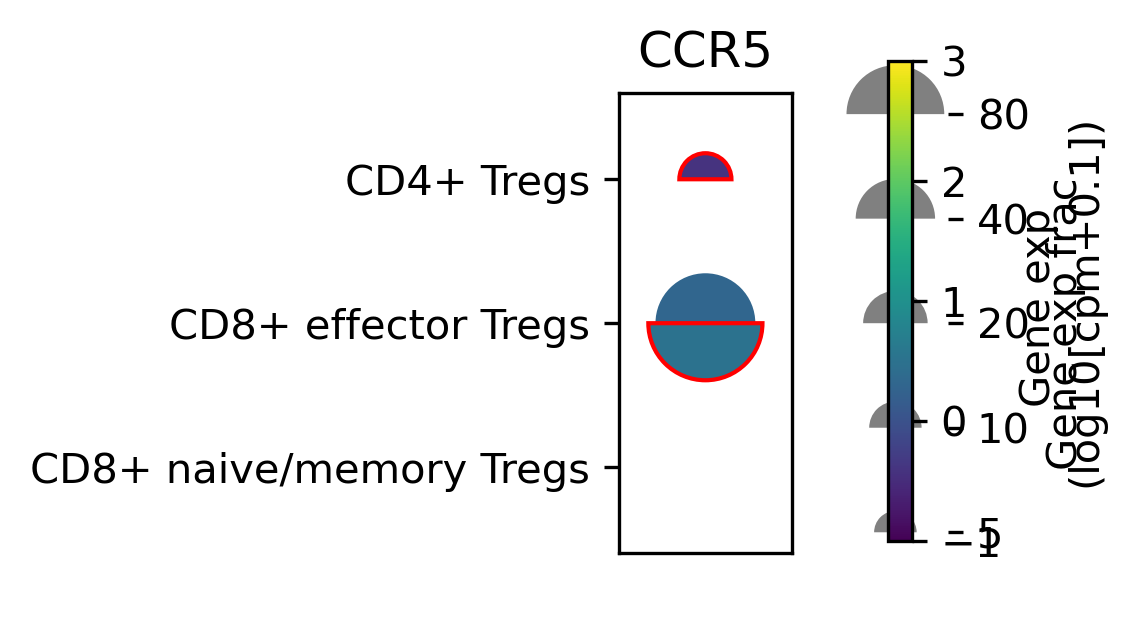

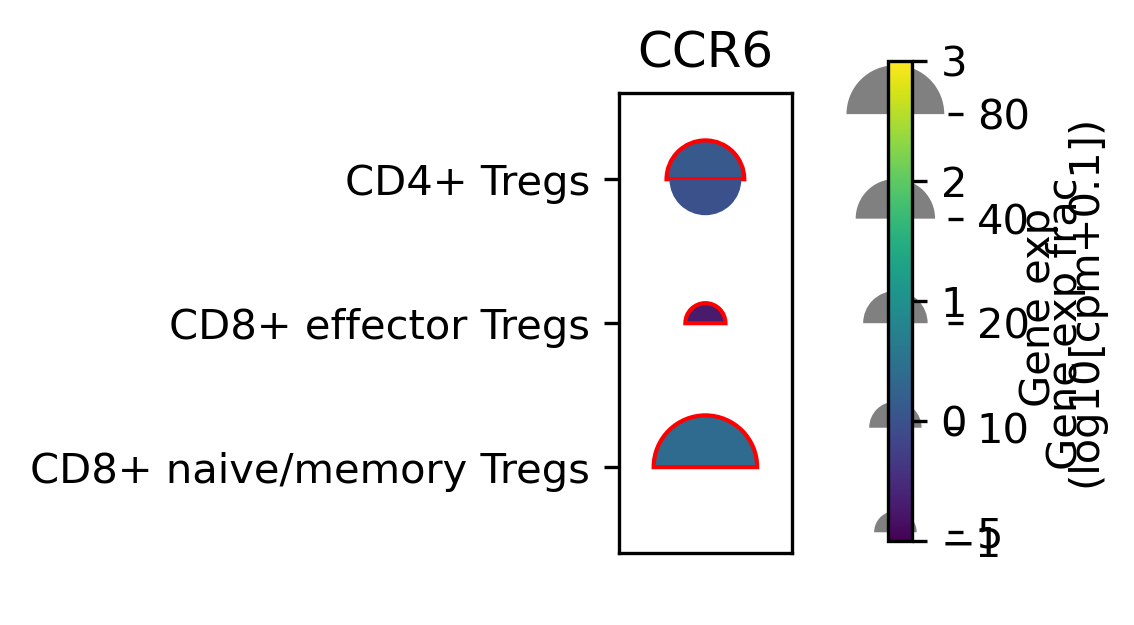

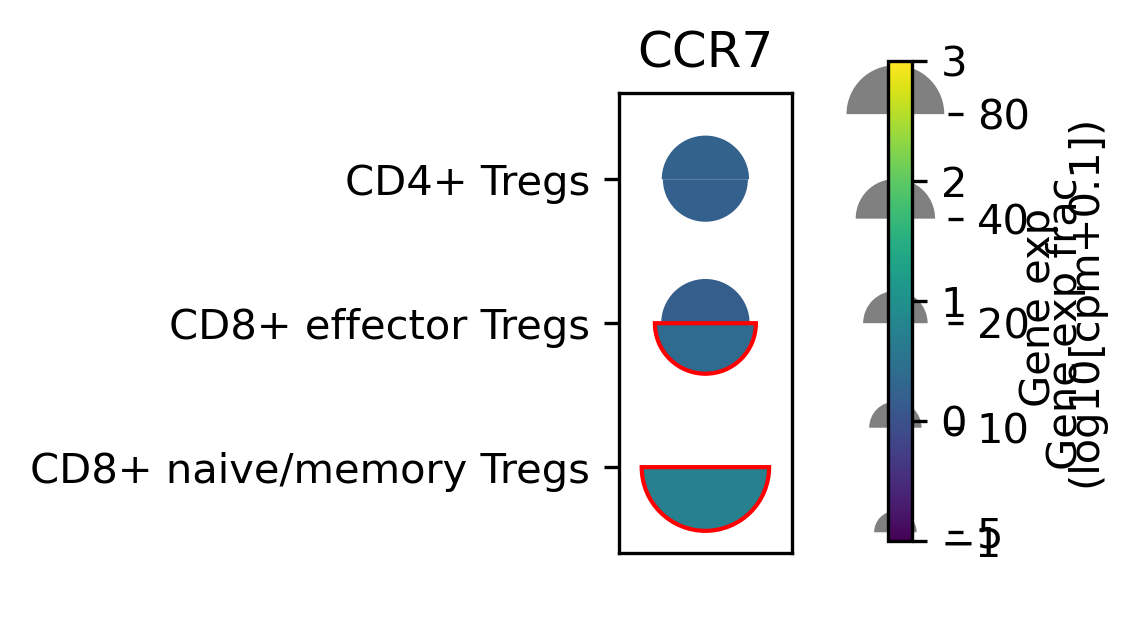

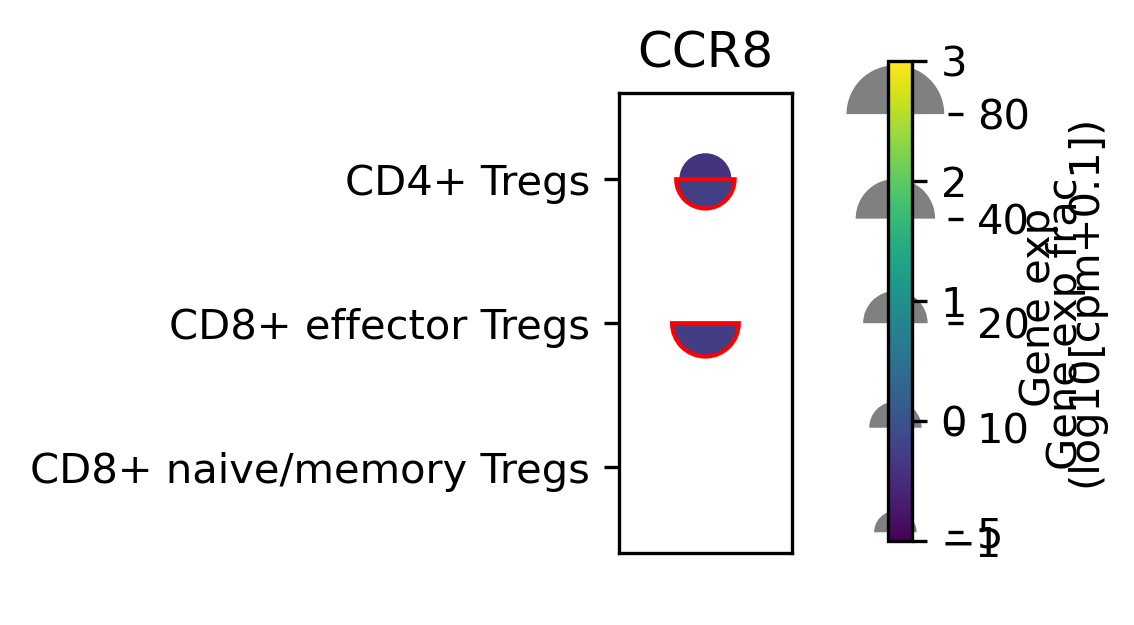

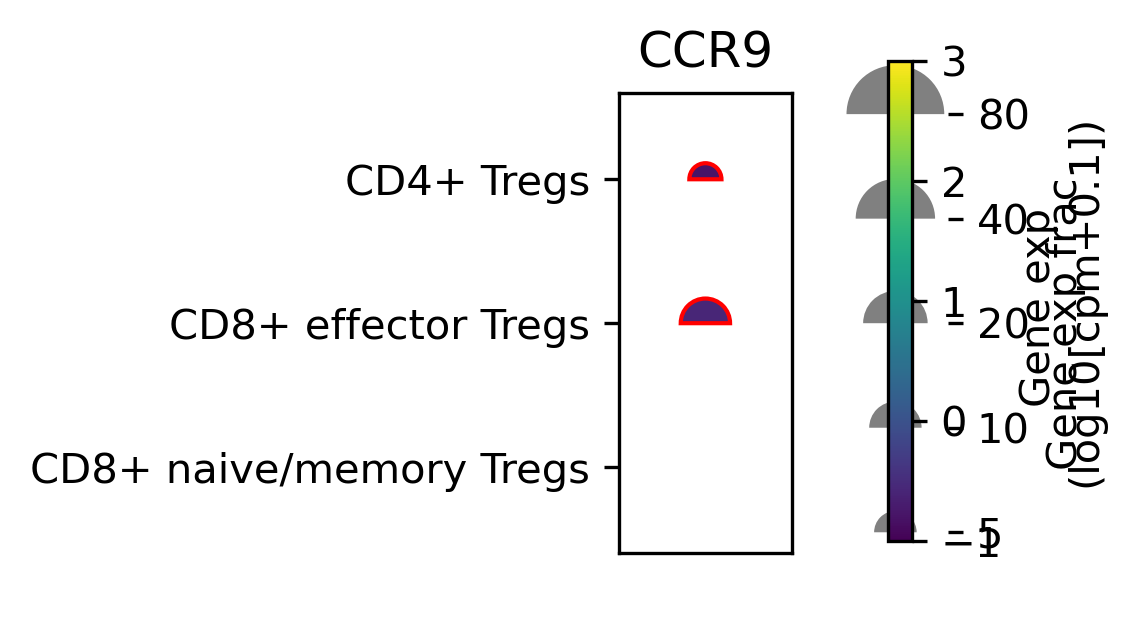

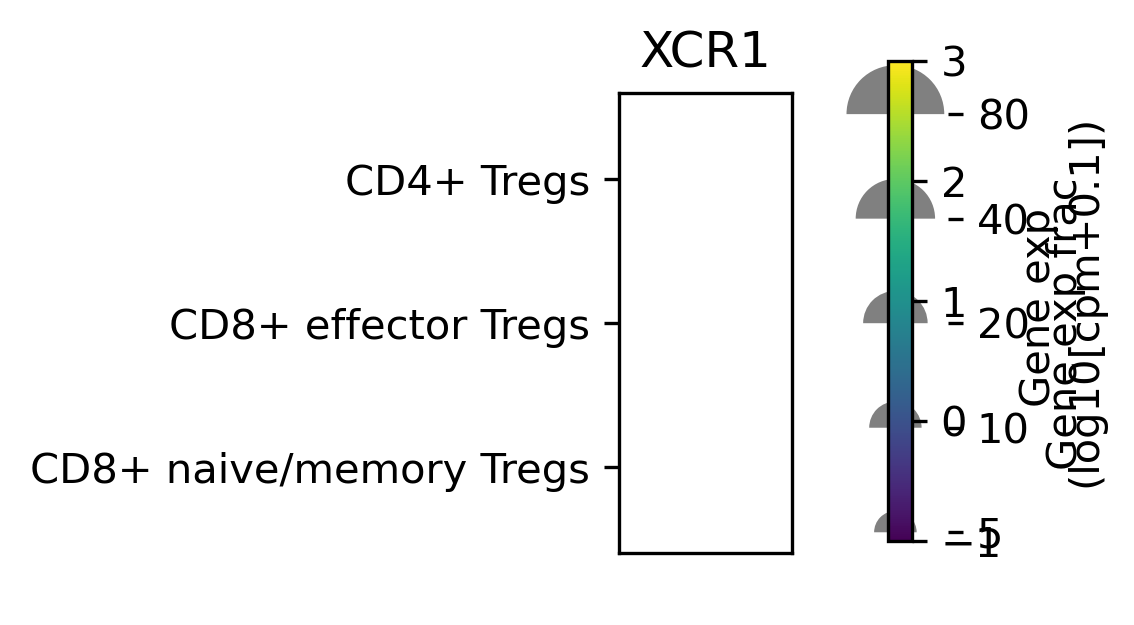

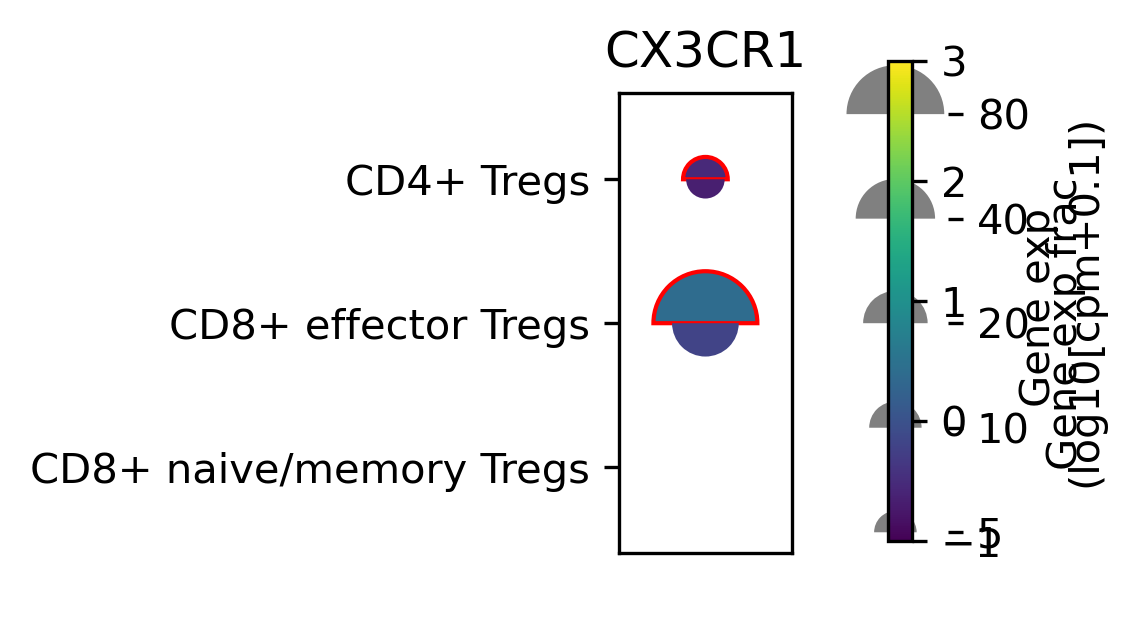

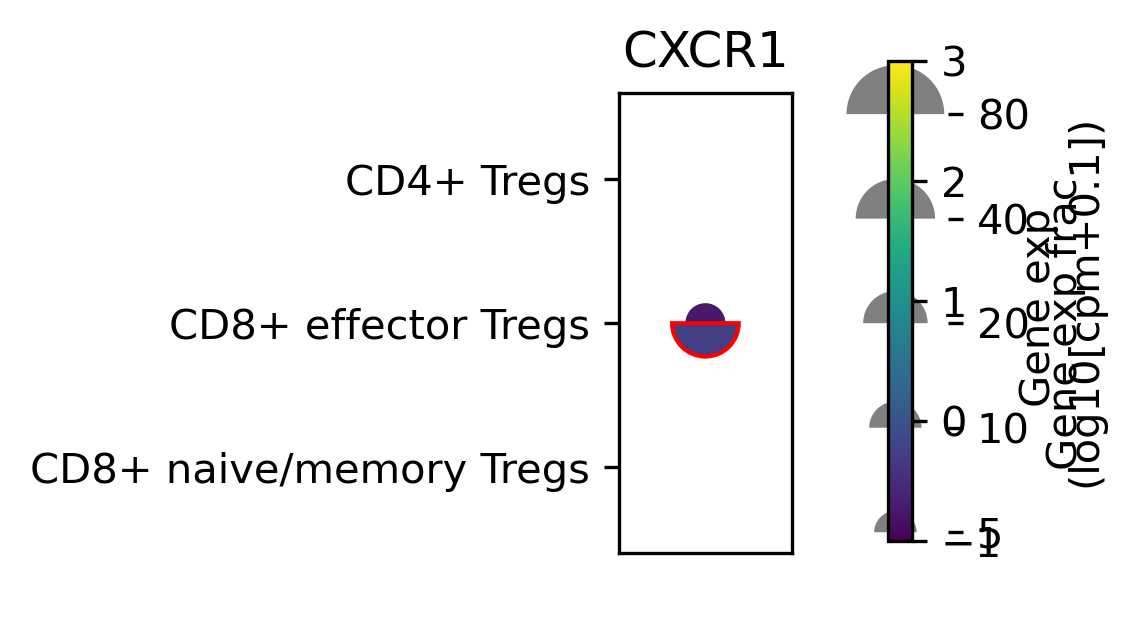

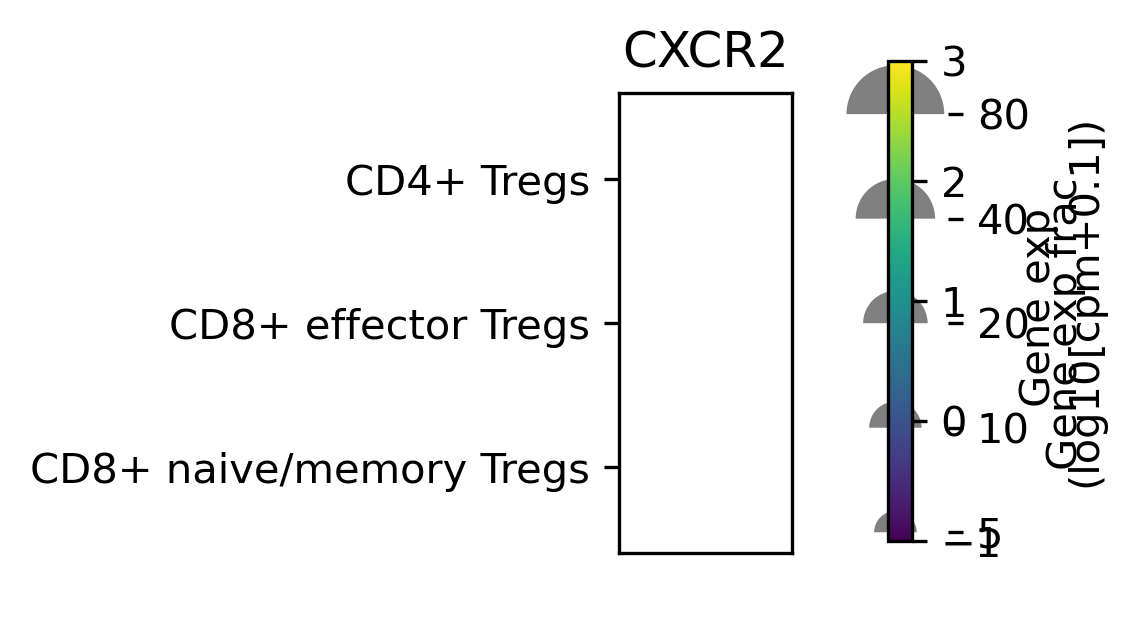

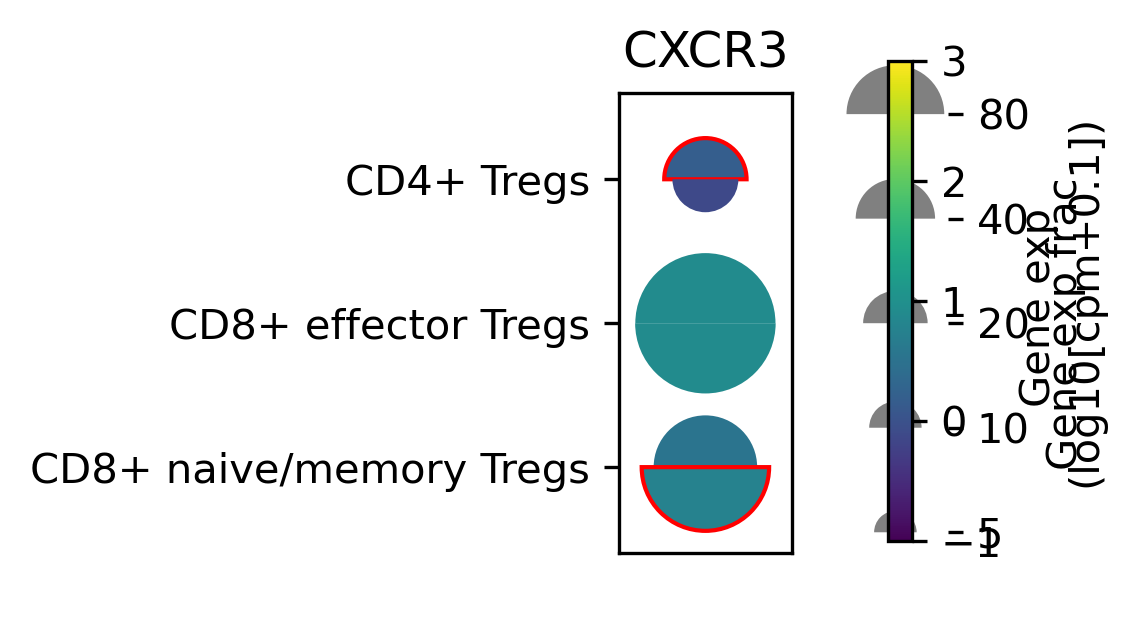

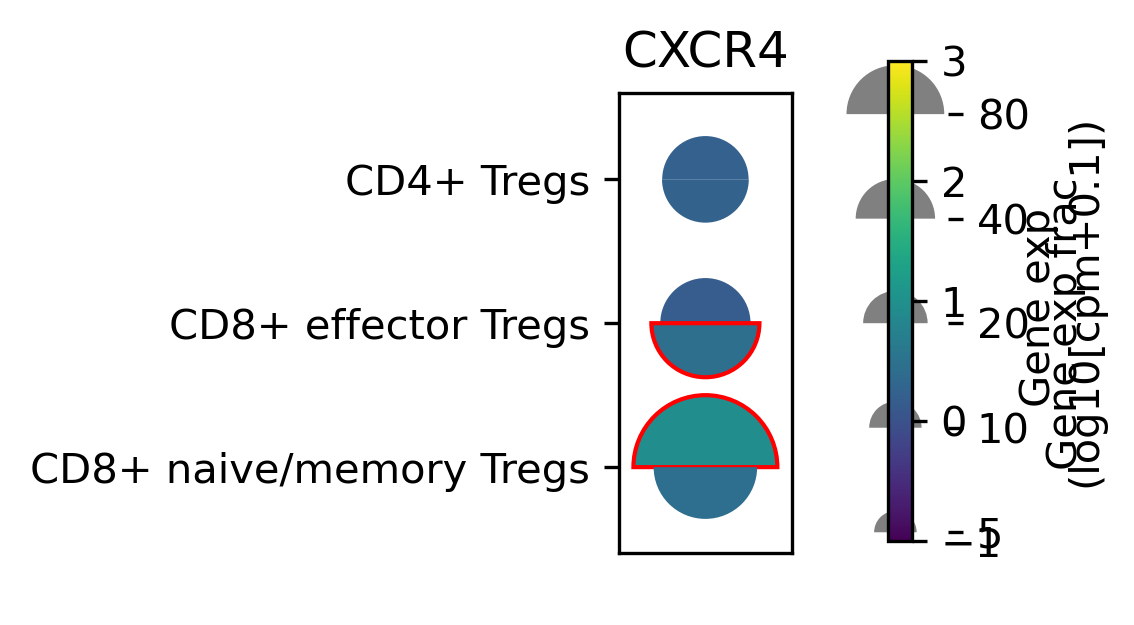

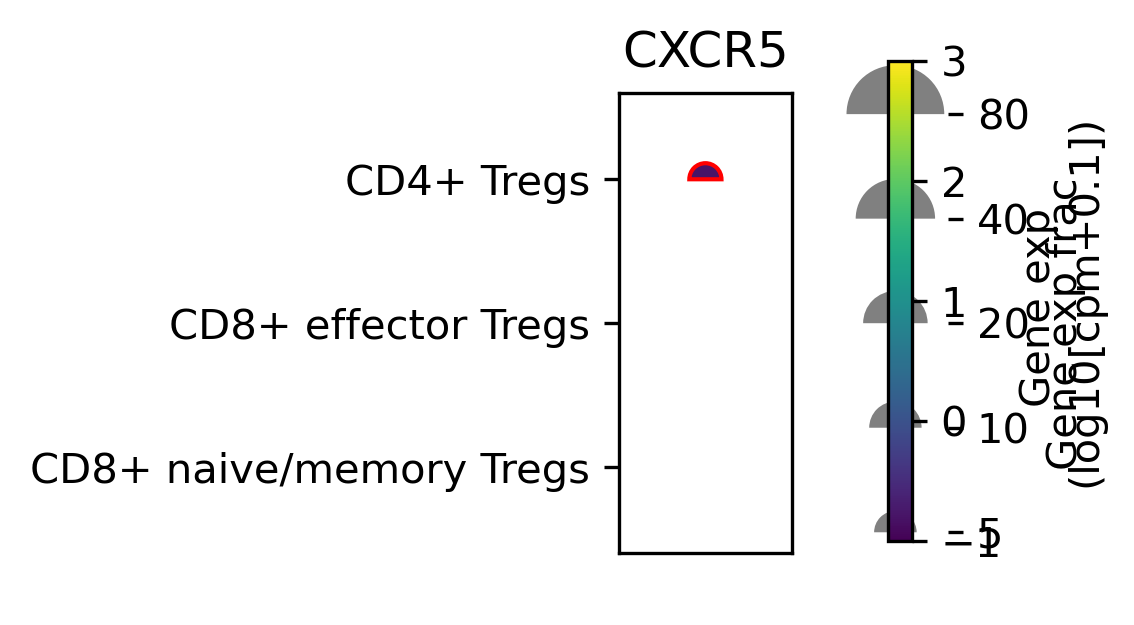

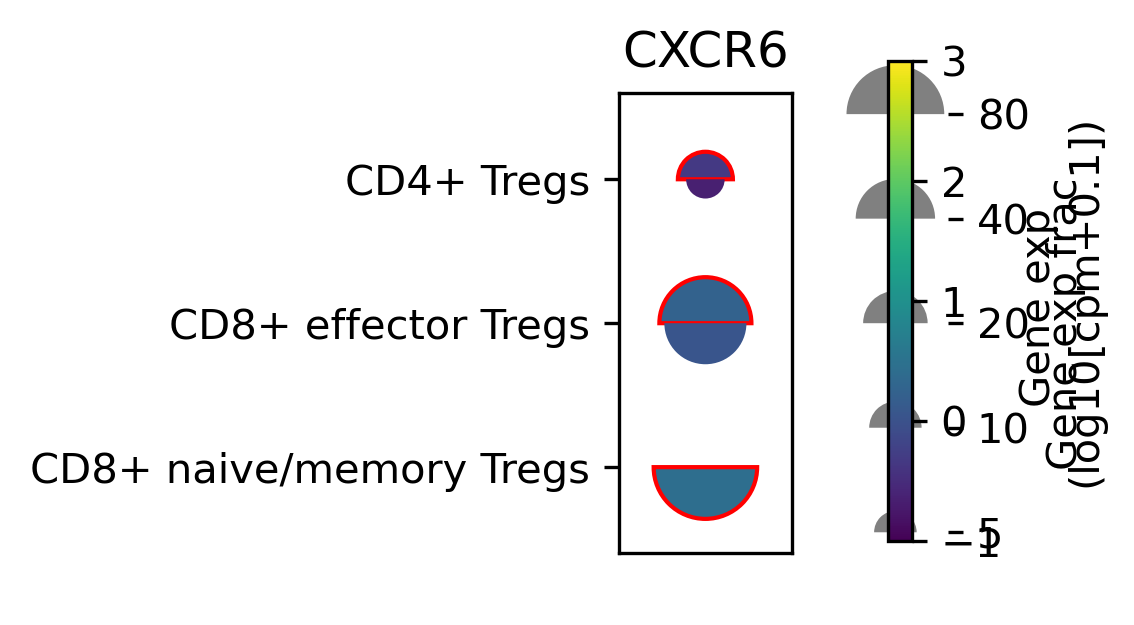

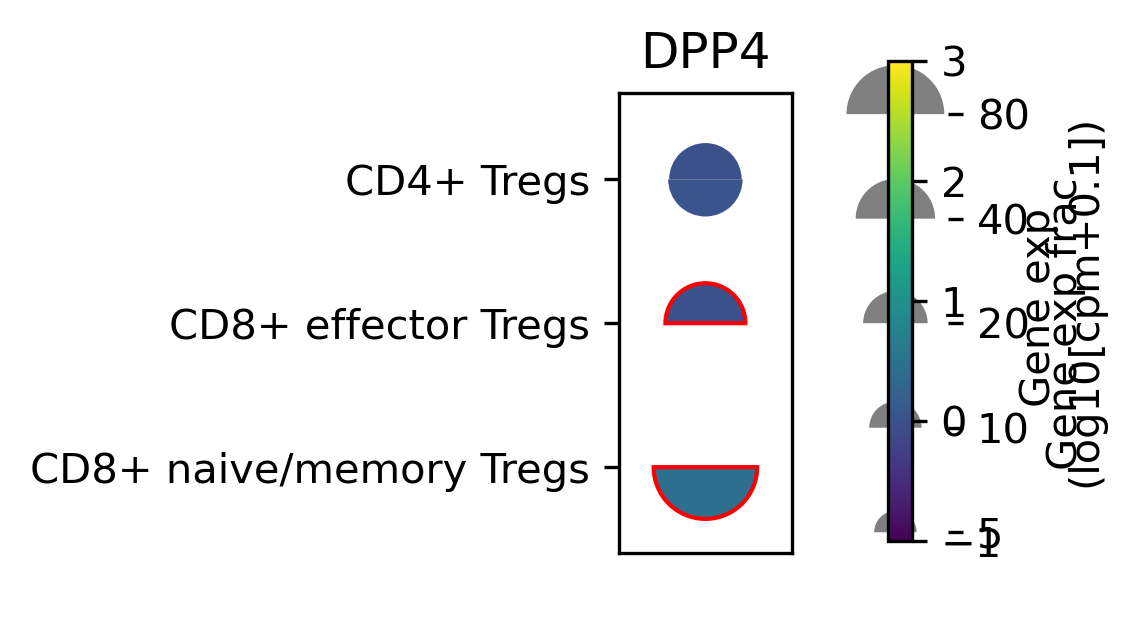

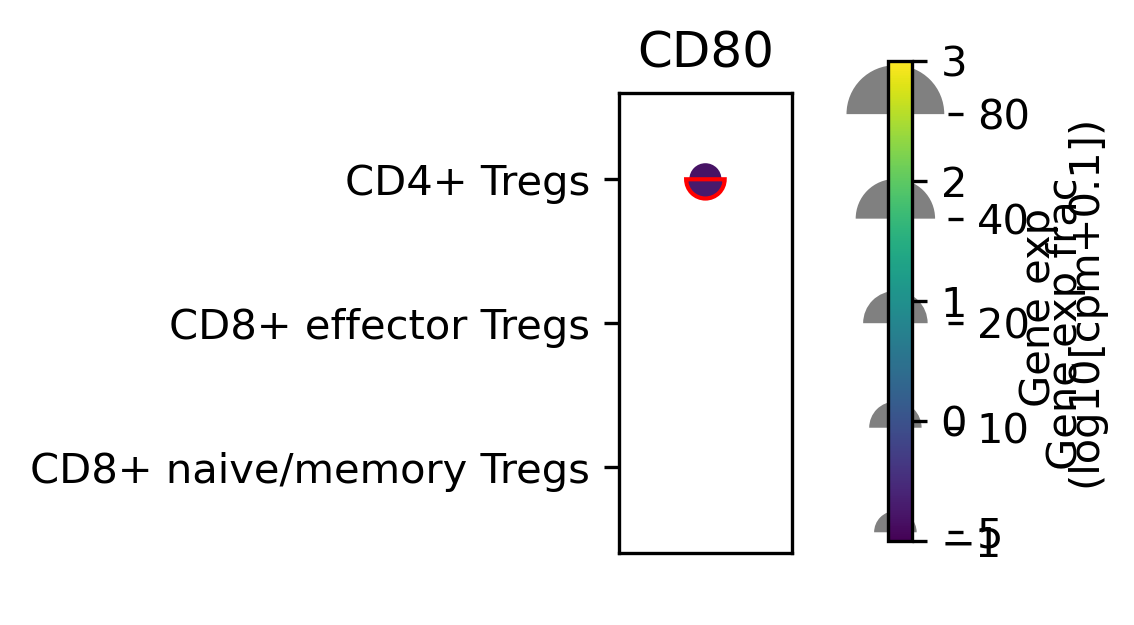

In [81]:
csts_plot = [  'CD4+ T cells',
               'CD8+ effector T cells',
               'CD8+ naive/memory T cells',
                 ]

csts_plot.reverse()

markers = ['ACKR1', 'ACKR2', 
           'CCR1',  'CCR2', 'CCR3', 'CCR4', 'CCR5', 'CCR6', 'CCR7', 'CCR8', 'CCR9', 'CCR10',
           'CXCR1', 'CXCR2', 'CXCR3', 'CXCR4', 'CXCR5', 'CXCR6',
           'XCR1', 
           'CX3CR1', 
           'DPP4', 'CD80',] 

for gene in markers:
    g = Treg_mushrooms([{gene: csts_plot}])['figure']
    g.savefig(save_figures + 'Tregs/Treg_receptors/' + gene + '.png', bbox_inches='tight')

<ipython-input-79-ef822fa27bbc>:34: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  axs.append(plt.subplot(grid[sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i]): sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i+1]), 0: 1]))
<ipython-input-79-ef822fa27bbc>:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


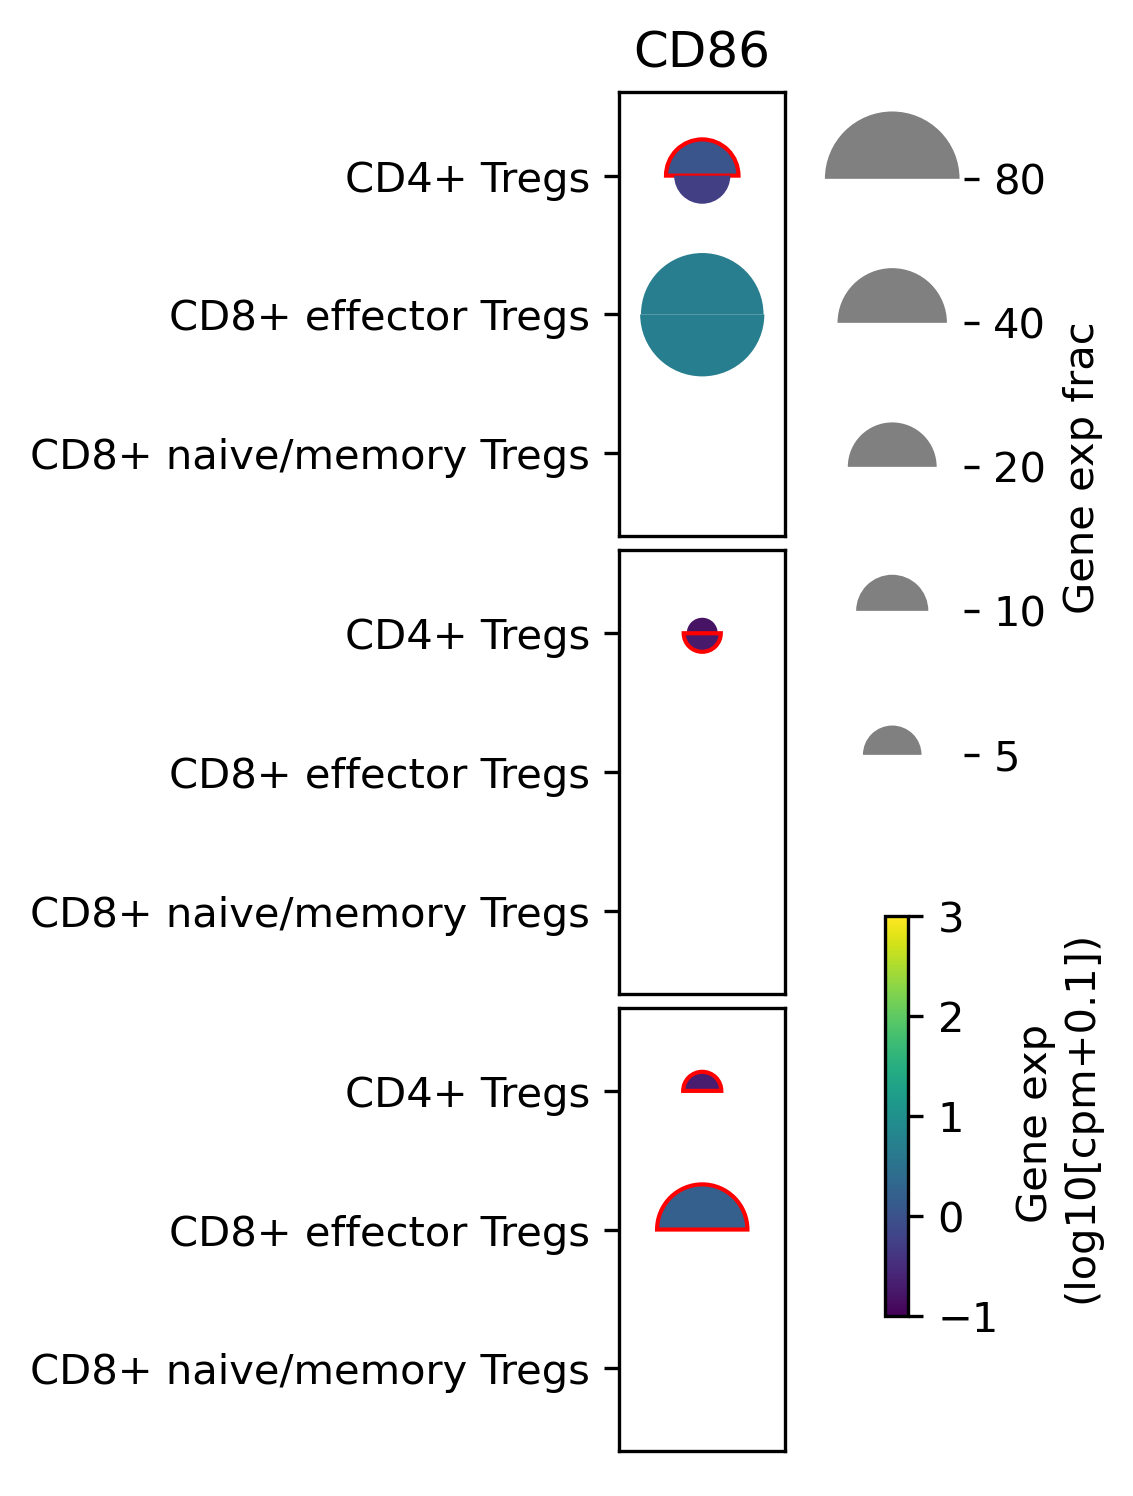

In [83]:
g = Treg_mushrooms([{'CTLA4': csts_plot},
                   {'CD80': csts_plot},
                   {'CD86': csts_plot},])['figure']
g.savefig(save_figures + 'Tregs/Treg_receptors/' + 'bar' + '.png', bbox_inches='tight')